# Проект: классификация

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, LabelBinarizer
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

import re

from sklearn.model_selection import GridSearchCV
import optuna

from colorama import Fore, Back, Style

In [2]:
# добавим пикселей для графиков, чтобы не так мыльно и уныло смотрелись
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# Выявляем признак с наибольшим количеством пропусков типа NULL
df.isnull().sum().sort_values(ascending=False).head(1)

balance    25
dtype: int64

### Задание 2

In [5]:
# Проверяем признак job на возможное указание неизвестного отличным от NULL способом
df.job.value_counts()
# Такой есть - unknown

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [6]:
#Вырежем пробелы, запятые и знак доллара и приведем признак к типу float
df.balance = df.balance.apply(lambda x: re.sub(r",00\s\$|\s\$|\s",'',str(x))).astype('float')
# Средний баланс
mean_balance = df.balance.mean()
mean_balance.round(3)

1529.129

### Задание 4

In [7]:
# заменим пропущенные значения медианым балансом
df.balance.fillna(df.balance.median(), inplace=True)
# теперь средний баланс равен
df.balance.mean().round(3)


1526.936

### Задание 5

In [8]:
# заполним пробелы в типе работы на медианную
df.loc[df.job[df.job == 'unknown'].index,'job'] = df.job.value_counts().idxmax()

# заполним пробелы в типе образования также на медианную
df.loc[df.education[df.education == 'unknown'].index,'education'] = df.education.value_counts().idxmax()

In [9]:
# рассчитаем средний баланс для клиентов с самой популярной работой 
# и самым популярным уровнем образования 
df[(df.job == df.job.value_counts().idxmax()) \
  & (df.education == df.education.value_counts().idxmax())].\
    balance.mean().round(3)

1598.883

### Задание 6

In [10]:
def get_outliers_bonds(data, feature):
    """Определяем границы диапазонов для ограничения значений по методу Тьюки"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper

In [11]:
lower_bound, upper_bound = get_outliers_bonds(df, 'balance')
# вычиляем верхню и нижнюю границы поиска выбросов по методу Тьюки
print(lower_bound)
print(upper_bound)


-2241.0
4063.0


In [12]:
# Создадим новый датафрэйм с удаленными записями найденных выьров по методу Тьюки
df_nb = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

In [13]:
# объектов после удаления всех выбросов
df_nb.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

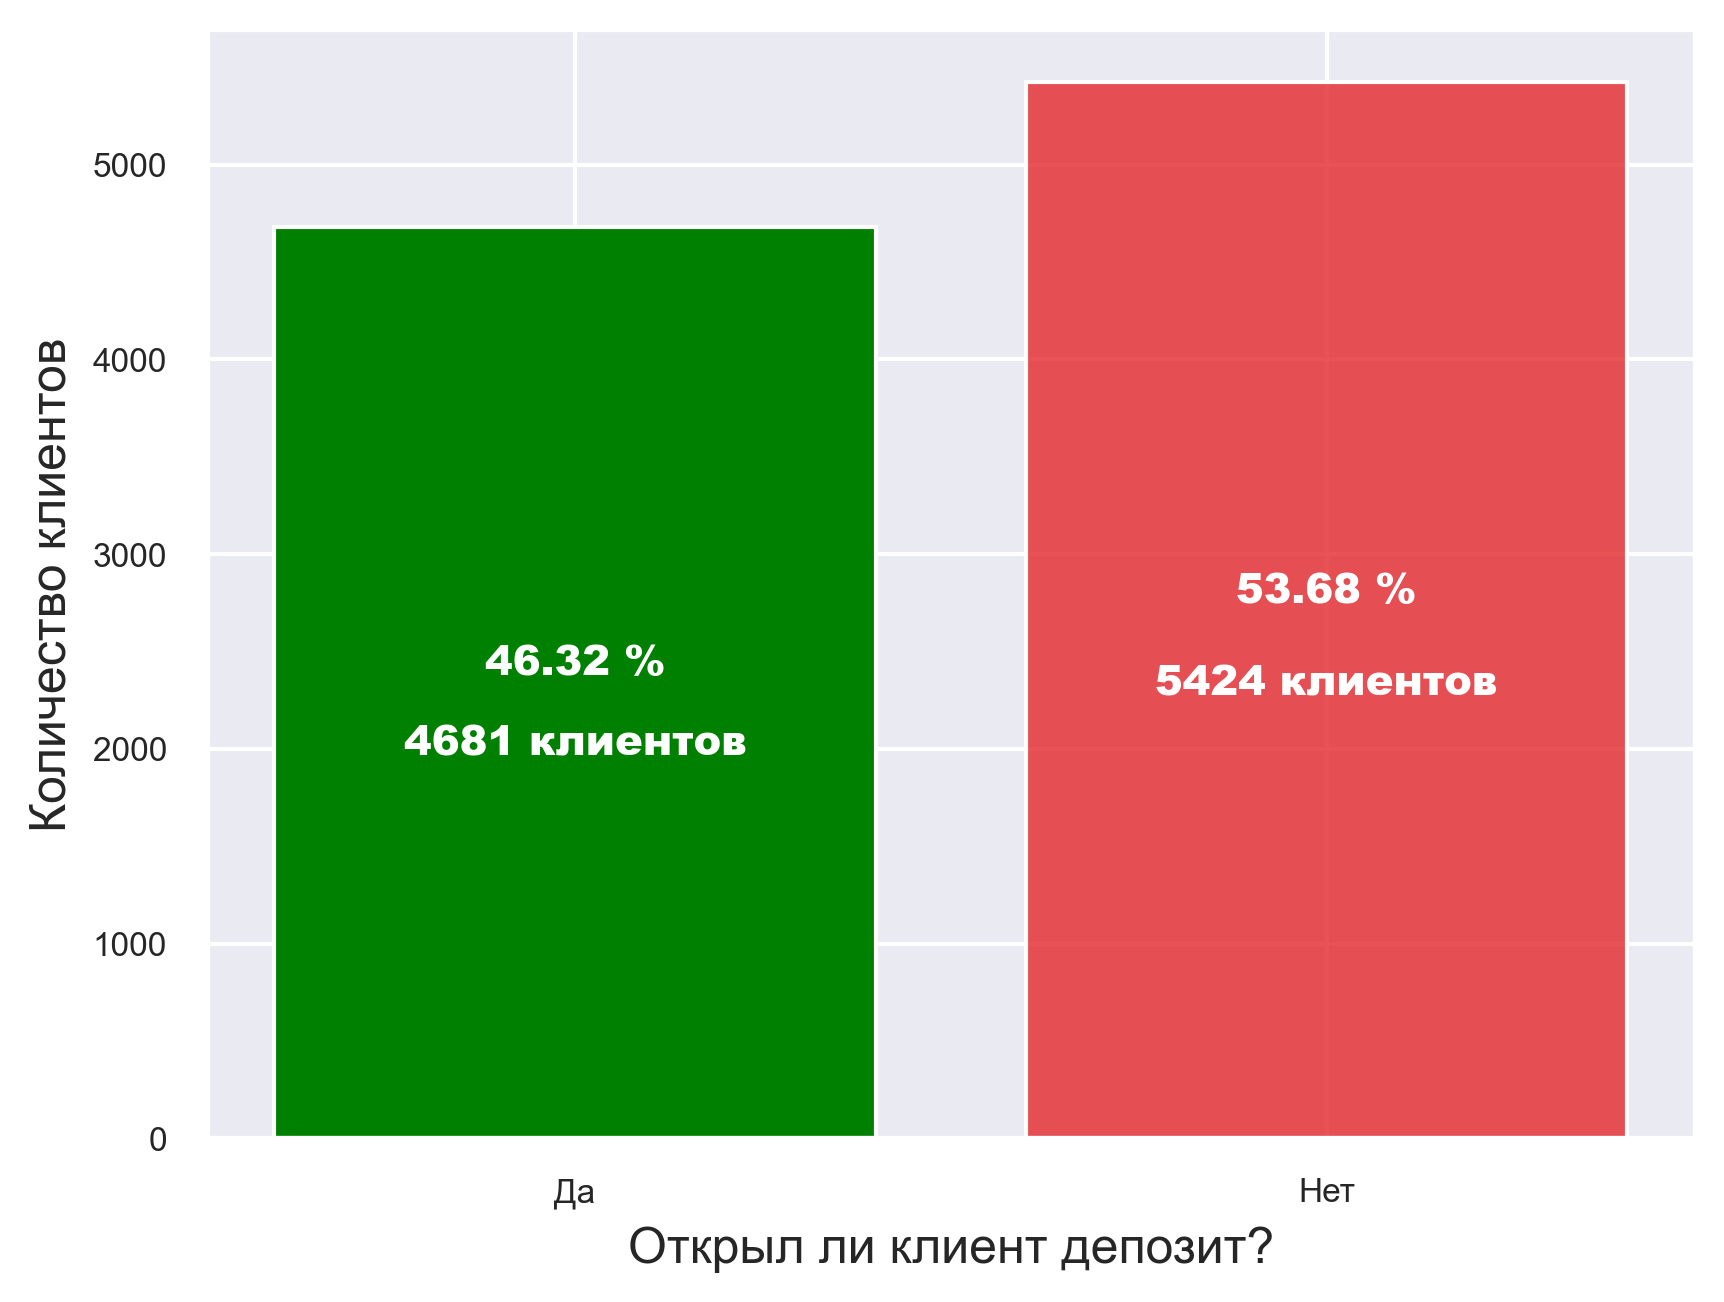

In [14]:
# проверим распределение целевой переменной
# Как видим по графику, можно сказать, что распределение достаточно сбаланcировано
pal2 = sns.color_palette("Set1", 12)
sns.set_palette(pal2)

total_count = df_nb.shape[0]

ax = sns.histplot(df_nb, x = df_nb.deposit, stat='count', shrink=.8)

for p in ax.patches:
    ax.annotate(
    '{:.2f} %'.format(p.get_height()/total_count*100), (p.get_x()+0.4, p.get_height()-(p.get_height()/2)),
    ha='center', va='bottom', fontsize=10, color = 'white', weight = 'heavy')
    ax.patches[0].set_facecolor('green')
    ax.annotate(
    '{} клиентов'.format(p.get_height()), (p.get_x()+0.4, p.get_height()-(p.get_height()/1.7)),
    ha='center', va='bottom', fontsize=10, color = 'white', weight = 'heavy')
    ax.patches[0].set_facecolor('green')


ax.set_xlabel('Открыл ли клиент депозит?')
ax.set_ylabel('Количество клиентов')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_major_formatter('{x:.0f}')
ax.set_xticklabels(['Да', 'Нет']);

### Задания 2 и 3

In [15]:
def annotateBoxplot(ax, ds, feature, min = False, max = False):
    """Функция наносит на указанный график значения кванитилей

    Args:
        ax (ax): графический обьект
        ds (Dataframe): датасет
        feature (string): наименование признака датасета
    """
    q1 = ds[feature].quantile([.25]).item()
    q3 = ds[feature].quantile([.75]).item()
    iqr = q3 - q1
    text_data = [
      ds[feature].median(),
      q1,
      q3,
      q1 - 1.5 * iqr,
      q3 + 1.5 *iqr
  ]

    for t_data in text_data:
      ax.text(
          # нанесем медианное значение на график
              t_data, 
              0, 
              f'{t_data:.0f}', 
              ha='center', 
              va='center', 
              fontweight='bold', 
              size=9,
              color='white',
              bbox=dict(facecolor='#445A64',linewidth = .4))
      
    if max:
      ax.text(
        t_data := ds[feature].max(),
        0.1,
        f'{t_data:.0f} Max', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=9,
        color='white',
        bbox=dict(facecolor='#e6067e',linewidth = .4))
    if min:
      ax.text(
        t_data := ds[feature].min(),
        0.1,
        f'{t_data:.0f} Min', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=9,
        color='white',
        bbox=dict(facecolor='#e69b06',linewidth = .4))      

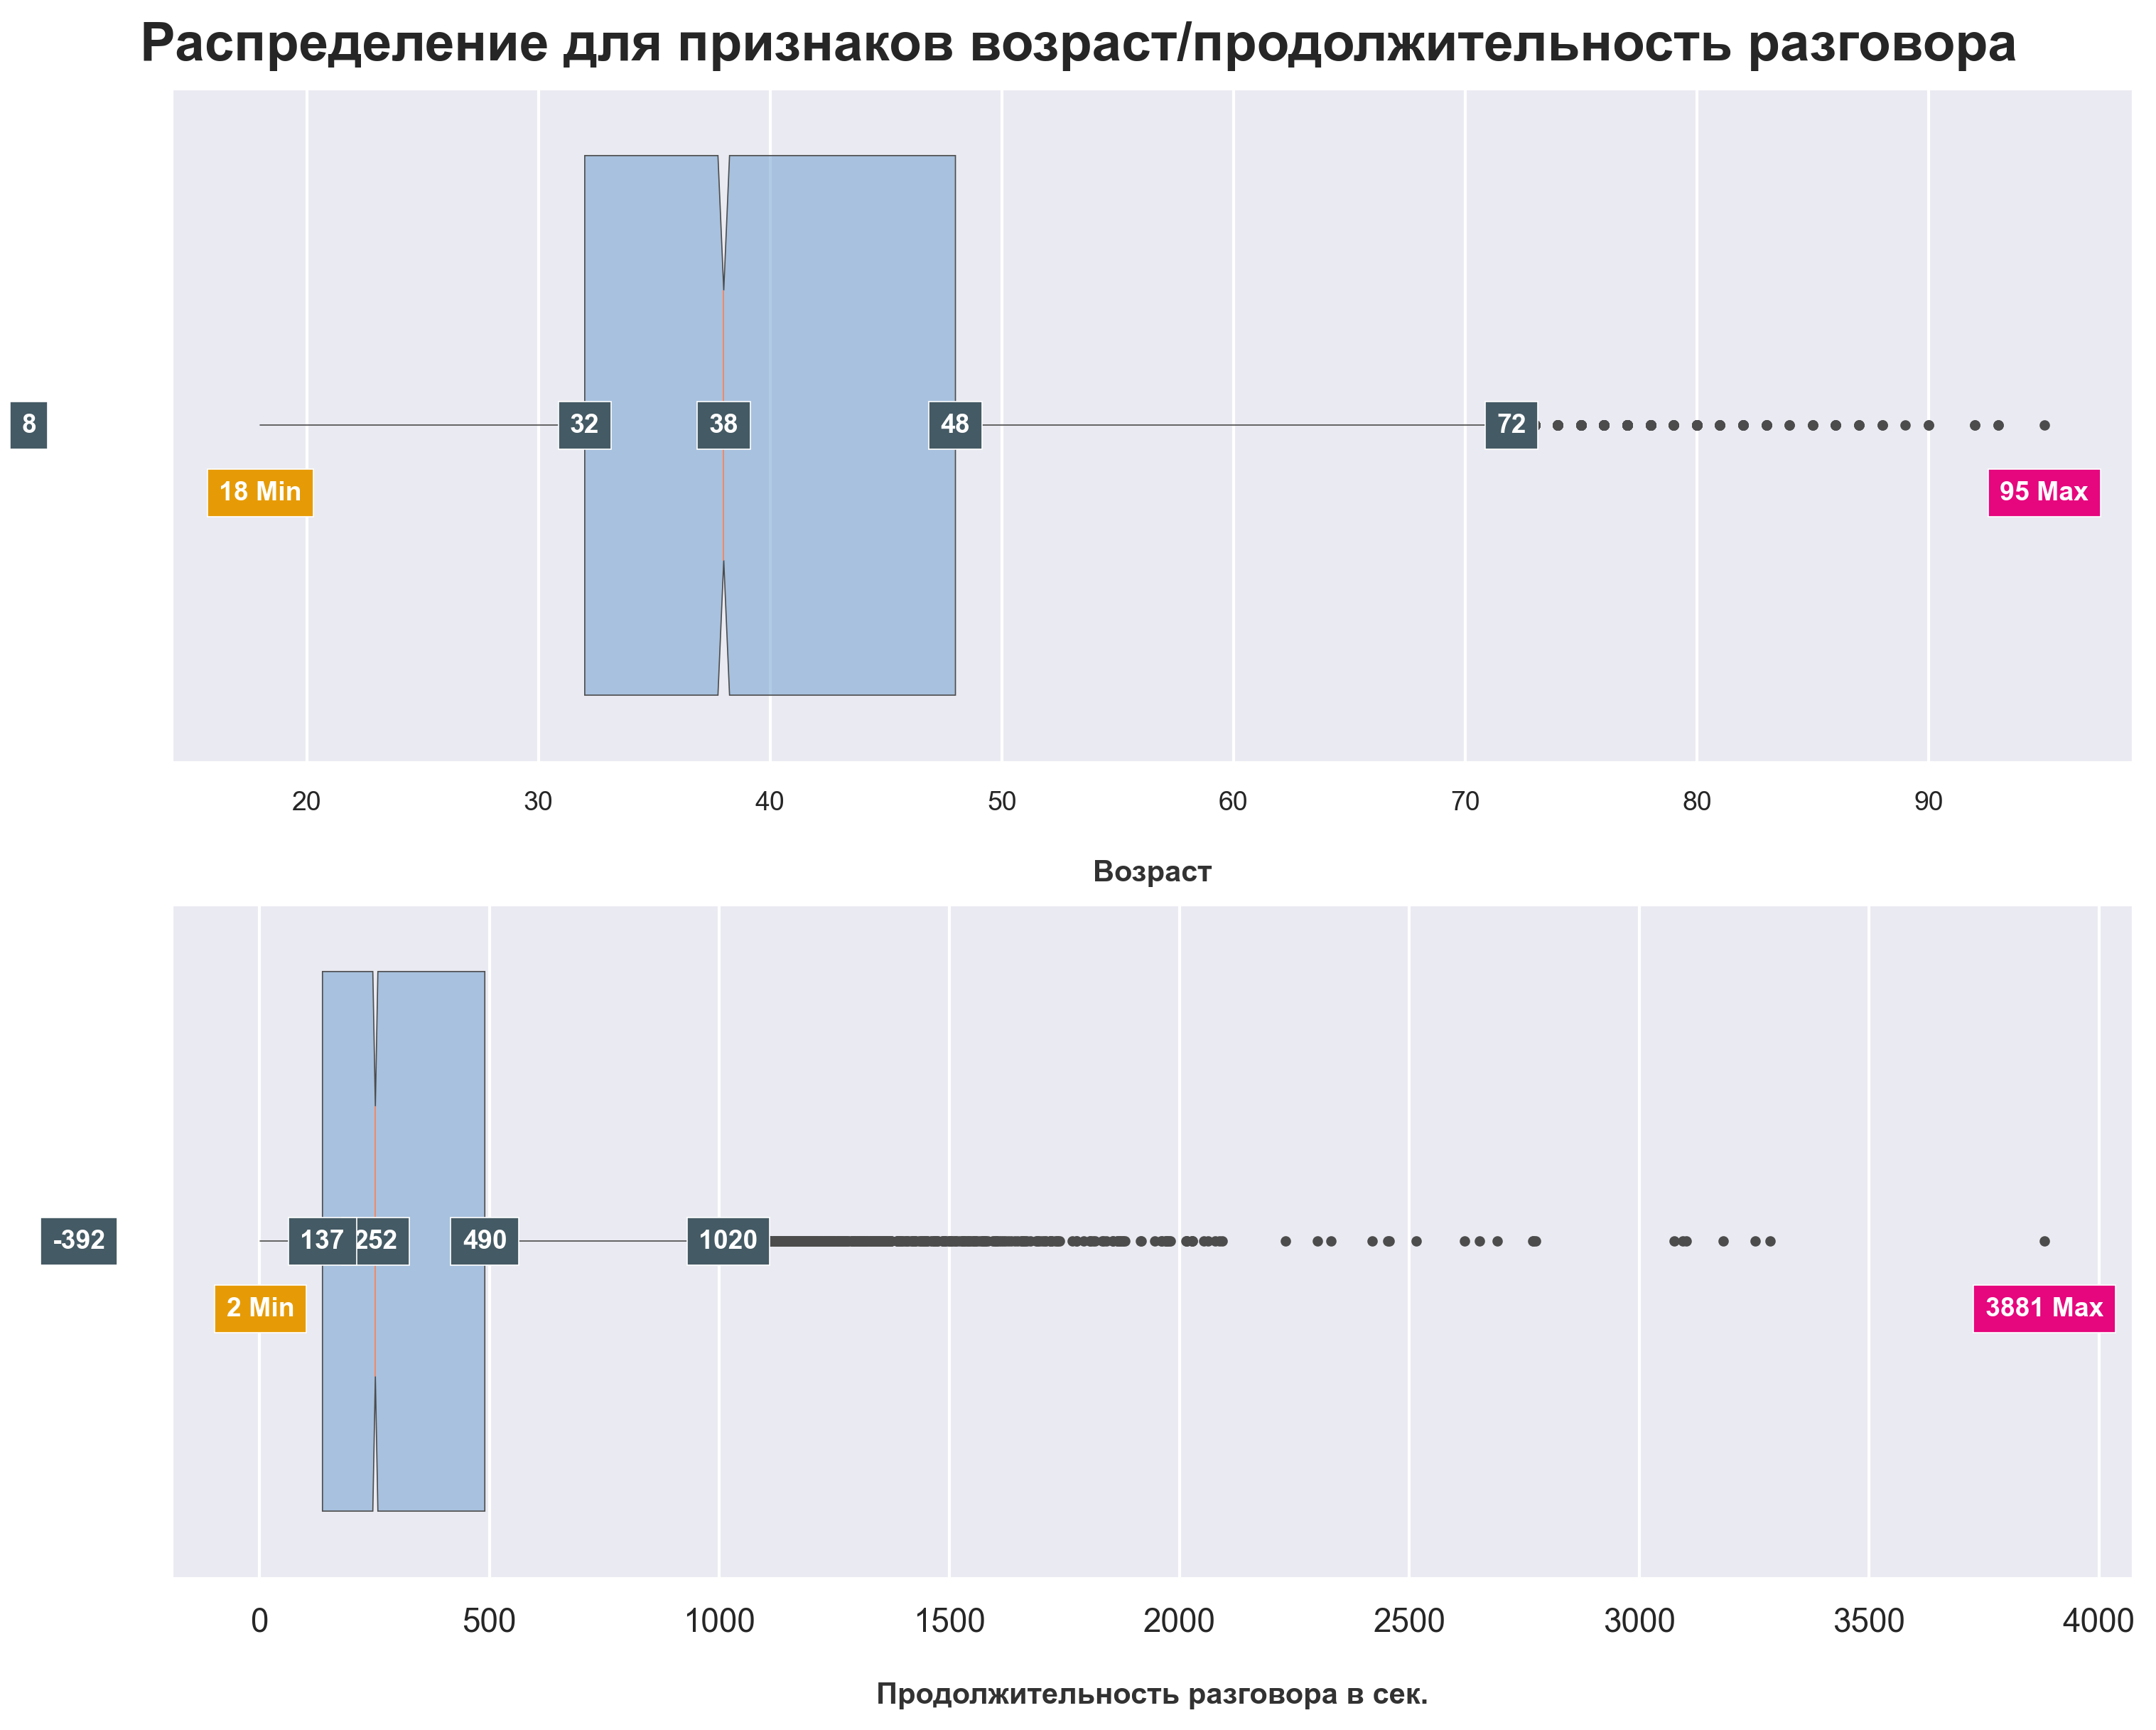

In [16]:
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)

# Выставим тему и стиль для графиков
sns.set_theme(style="whitegrid", palette="pastel")

rc_style={'patch.edgecolor': 'w',
          'grid.color': '.8',
          'grid.linestyle': "-",
          }
sns.set(rc={"grid.linewidth":.3})
sns.set_style("darkgrid",rc_style)


sns.boxplot(
    data=df_nb, x="age",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    linewidth=.4,
    ax = ax1
);

sns.boxplot(
    data=df_nb, x="duration",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
    linewidth=.4,
    ax = ax2
);
# # для пущей визуализации нанесем значения квантилей, медианы и нижнего заборчика
# # на график, предварительно рассчитав их

annotateBoxplot(ax1, df_nb, 'age', min = True, max = True)
annotateBoxplot(ax2, df_nb, 'duration', min=True, max = True)
    

#modify individual font size of elements
plt.suptitle('Распределение для признаков возраст/продолжительность разговора', size = 18, weight = 600)
ax1.set_xlabel('Возраст', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_xlabel('Продолжительность разговора в сек.', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.tick_params(axis='both', which='major', labelsize=9)

### Задания 4 и 5

In [17]:
print(f"{Fore.LIGHTBLUE_EX}Количество месяцев, когда проводились компании:\
  {Fore.LIGHTGREEN_EX} {df_nb.month.nunique()}")
print(f"{Fore.LIGHTBLUE_EX}Количество представленных сфер занятости:\
  {Fore.LIGHTGREEN_EX} {df_nb.job.nunique()}")

Количество месяцев, когда проводились компании:   12
Количество представленных сфер занятости:   11


### Задание 6

In [18]:
# Получим датафрейм с разрезом по статусам успеха компании
poutcome_status = df_nb.groupby("poutcome")['deposit'].value_counts(normalize=False).to_frame().reset_index()

# Вычислим процентное соотношения успеха компании по статусам
poutcome_percent = df_nb.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
poutcome_percent['percent'] = (poutcome_percent.yes/poutcome_percent.no * 100).round(2)
poutcome_percent = poutcome_percent.reset_index()[['poutcome', 'percent']]

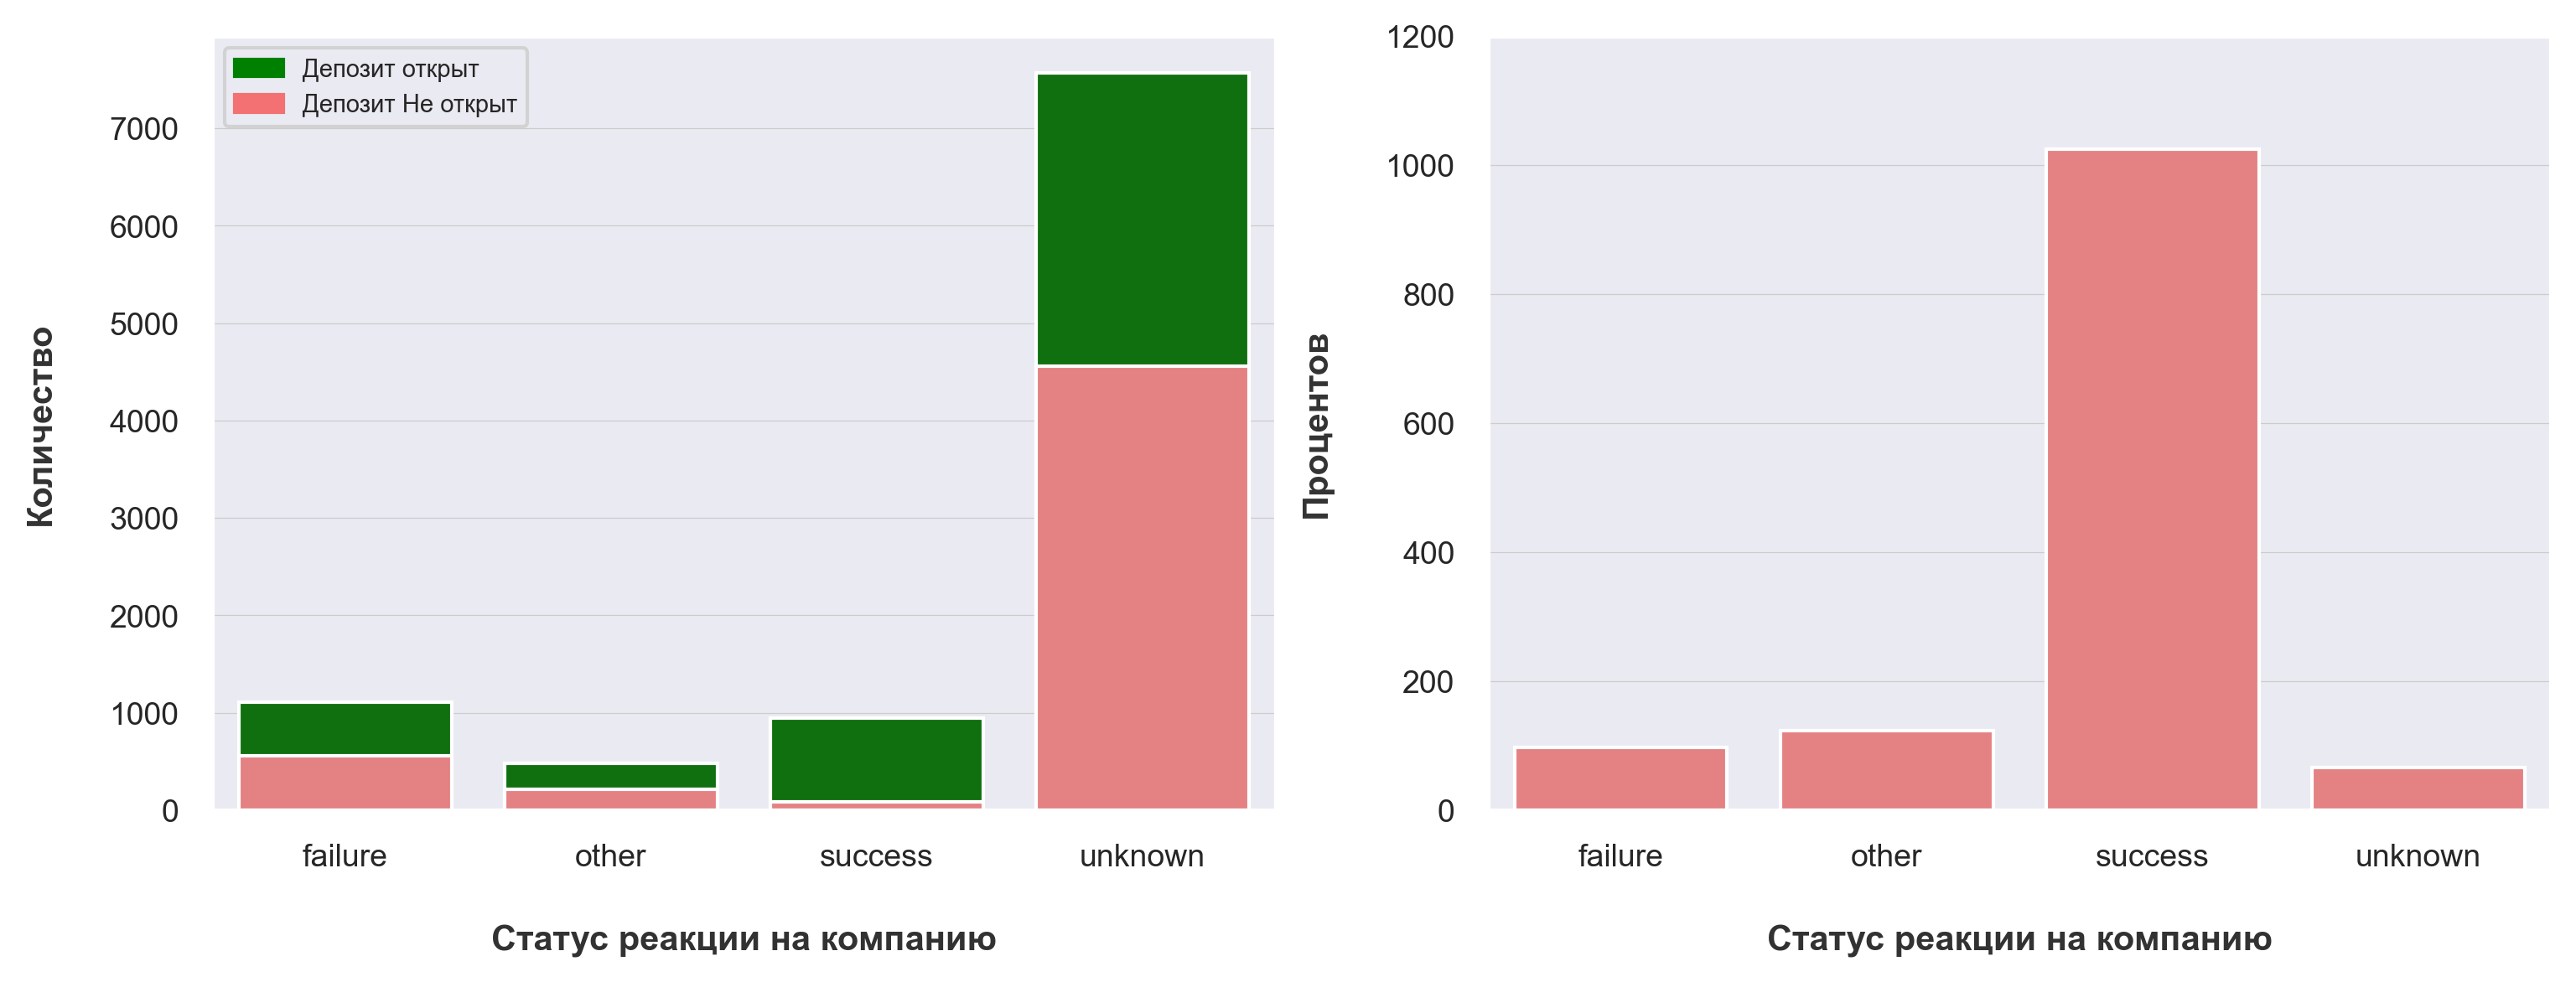

In [19]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=False, sharey=False)


ax = sns.barplot(data=poutcome_status[['poutcome','count']].groupby('poutcome').sum().reset_index(),
                  x='poutcome',
                  y= 'count',
                  color = 'green',
                  ax = ax1
);
sns.barplot(data=poutcome_status[poutcome_status.deposit == 'no'],
                  x='poutcome',
                  y= 'count',
                  color = '#f37173ff',
                  ax = ax1);

sns.barplot(data=poutcome_percent,
                  x='poutcome',
                  y= 'percent',
                  color = '#f37173ff',
                  ax = ax2);

ax2.set_ylim(0,1200)


top_bar = mpatches.Patch(color='green', label='Депозит открыт')
bottom_bar = mpatches.Patch(color='#f37173ff', label='Депозит Не открыт')
ax.legend(handles=[top_bar, bottom_bar], loc = 'upper left', fontsize = 7, edgecolor = '.8')

ax.set_xlabel('Статус реакции на компанию', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.set_ylabel('Количество', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.tick_params(axis='both', which='major', labelsize=9);

ax2.set_xlabel('Статус реакции на компанию', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_ylabel('Процентов', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.tick_params(axis='both', which='major', labelsize=9);


### Задание 7

In [20]:
df_nb_month_all_statuses = df_nb.groupby(["month","poutcome"])[['month','poutcome']].value_counts(normalize=False).to_frame().reset_index()

In [21]:
df_nb_month_requred_statuses = df_nb_month_all_statuses[df_nb_month_all_statuses.poutcome.isin(['failure','success'])]

In [22]:
df_nb_month_grouped = df_nb_month_requred_statuses.pivot(columns='poutcome', index='month', values='count').reset_index()
df_nb_month_grouped['ratio'] = (df_nb_month_grouped.failure/df_nb_month_grouped.success * 100).round(2)

# Месяц с самым большим отказом рекламной компании
print(f"{Fore.LIGHTBLUE_EX}Месяц с самым большим отказом рекламной компании:\
  {Fore.LIGHTGREEN_EX} {df_nb_month_grouped.sort_values(by='ratio', ascending=False).head(1).month.item()}")


Месяц с самым большим отказом рекламной компании:   may


In [23]:
new_order = ["jan", "feb", "mar", "apr", "may", "jun", 
          "jul", "aug", "sep", "oct", "nov", "dec"]
df_nb_month_grouped_ordered = df_nb_month_grouped.set_index('month').reindex(new_order, axis = 0).reset_index()

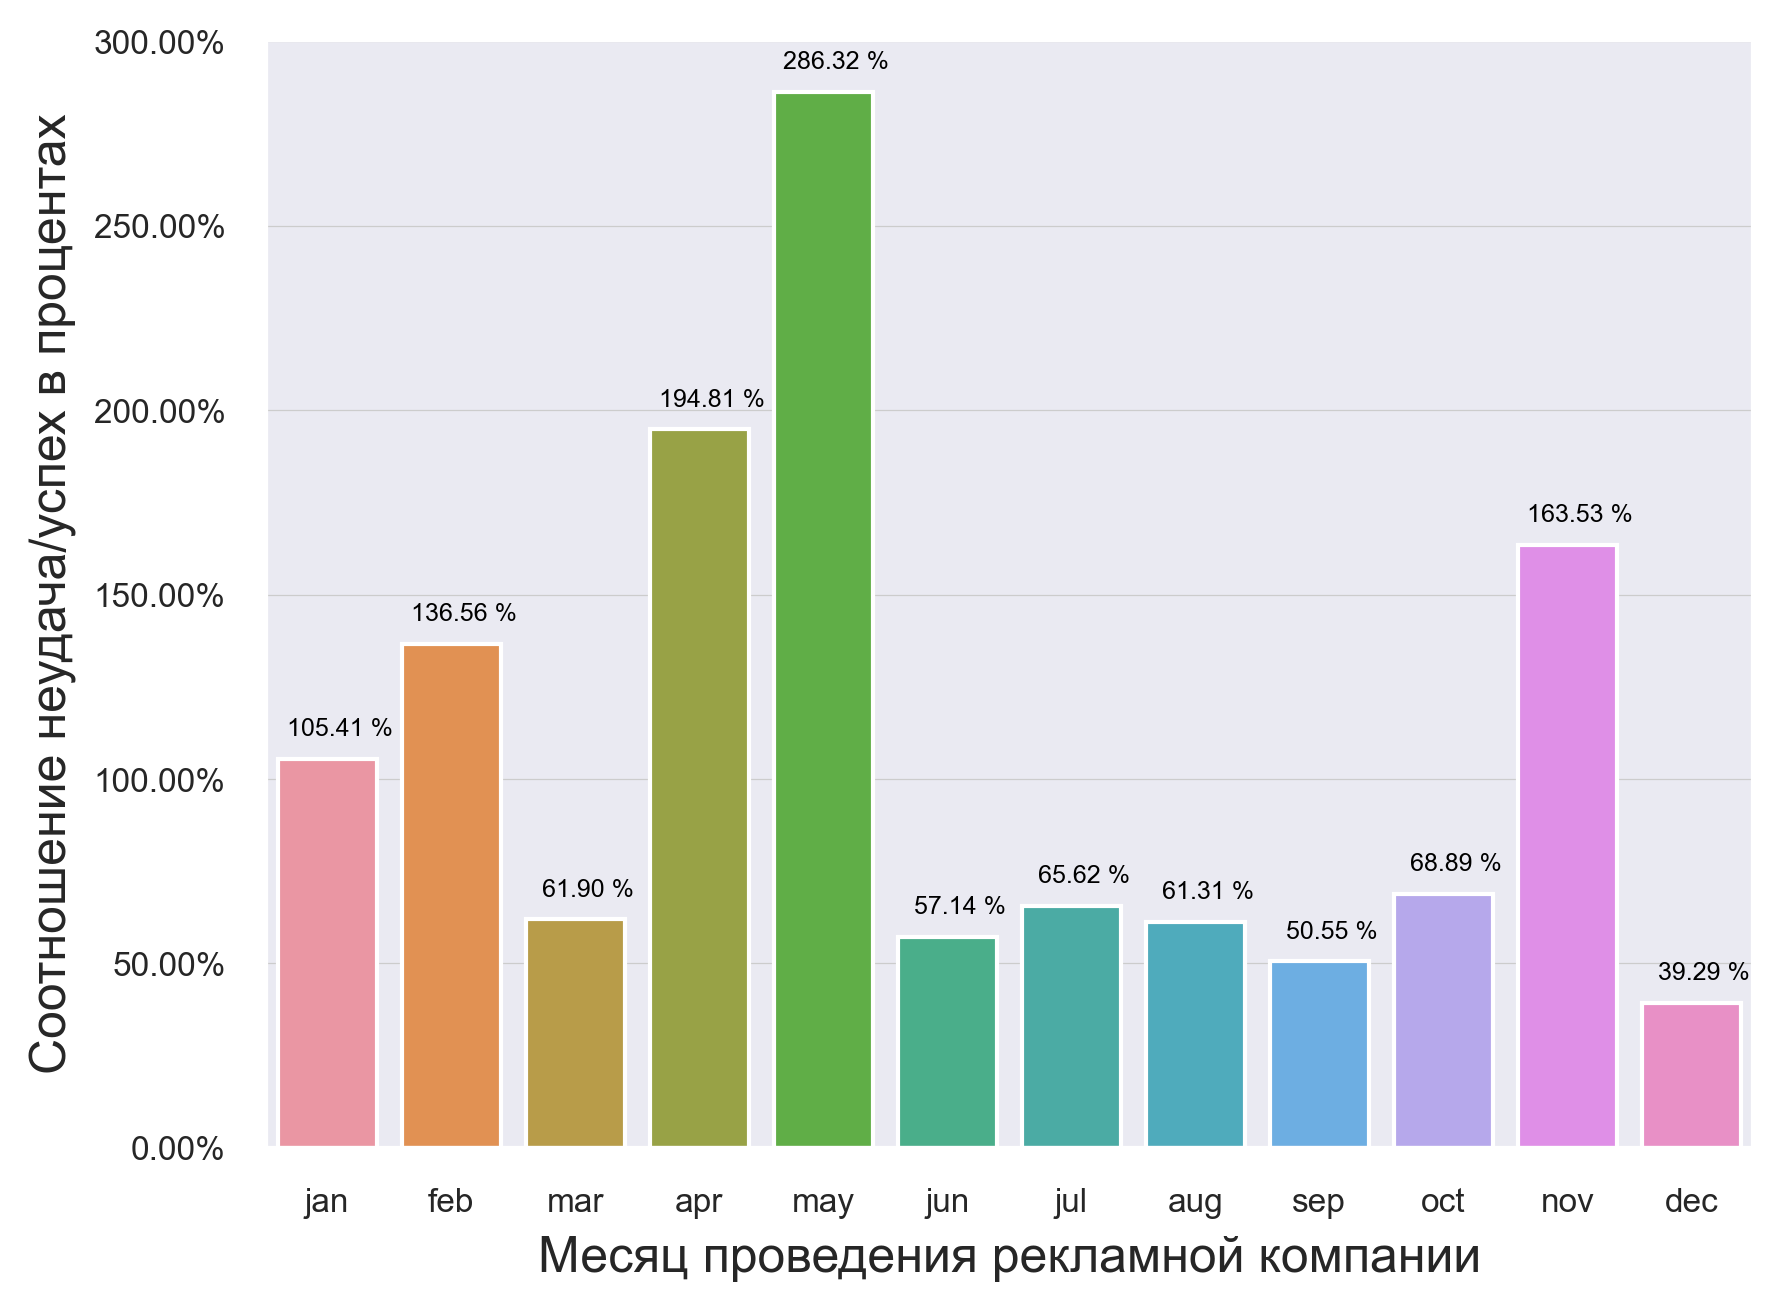

In [24]:
ax = sns.barplot(df_nb_month_grouped_ordered[['ratio','month']], x ='month', y='ratio')

for p in ax.patches:
    ax.annotate(
    '{:.2f} %'.format(p.get_height()), (p.get_x()+0.5, p.get_height()+5),
    ha='center', va='bottom', fontsize=6, color = 'black')


ax.set_xlabel('Месяц проведения рекламной компании')
ax.set_ylabel('Соотношение неудача/успех в процентах')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_major_formatter('{x:.2f}%')


Как мы видим, май самый неудачный месяц для проведения маркетинговой компании. Лучше всего дают результаты компании, проведенные летом и в начале осени, а также декабрь.

### Задание 8

In [25]:
df_nb['age_group'] = pd.cut(df_nb.age, [0,30,40,50,60,9999],
                            labels = ['<30','30-40','40-50','50-60','60+'])

# Вычислим соотношение открытия депозита по возрастным группам
df_ages = df_nb.groupby(['age_group','deposit'])[['age_group']].\
  count().unstack('deposit').droplevel(0, axis = 1).reset_index()
df_ages['deposit_open_ratio'] = (df_ages.yes/df_ages.no * 100).round(2)


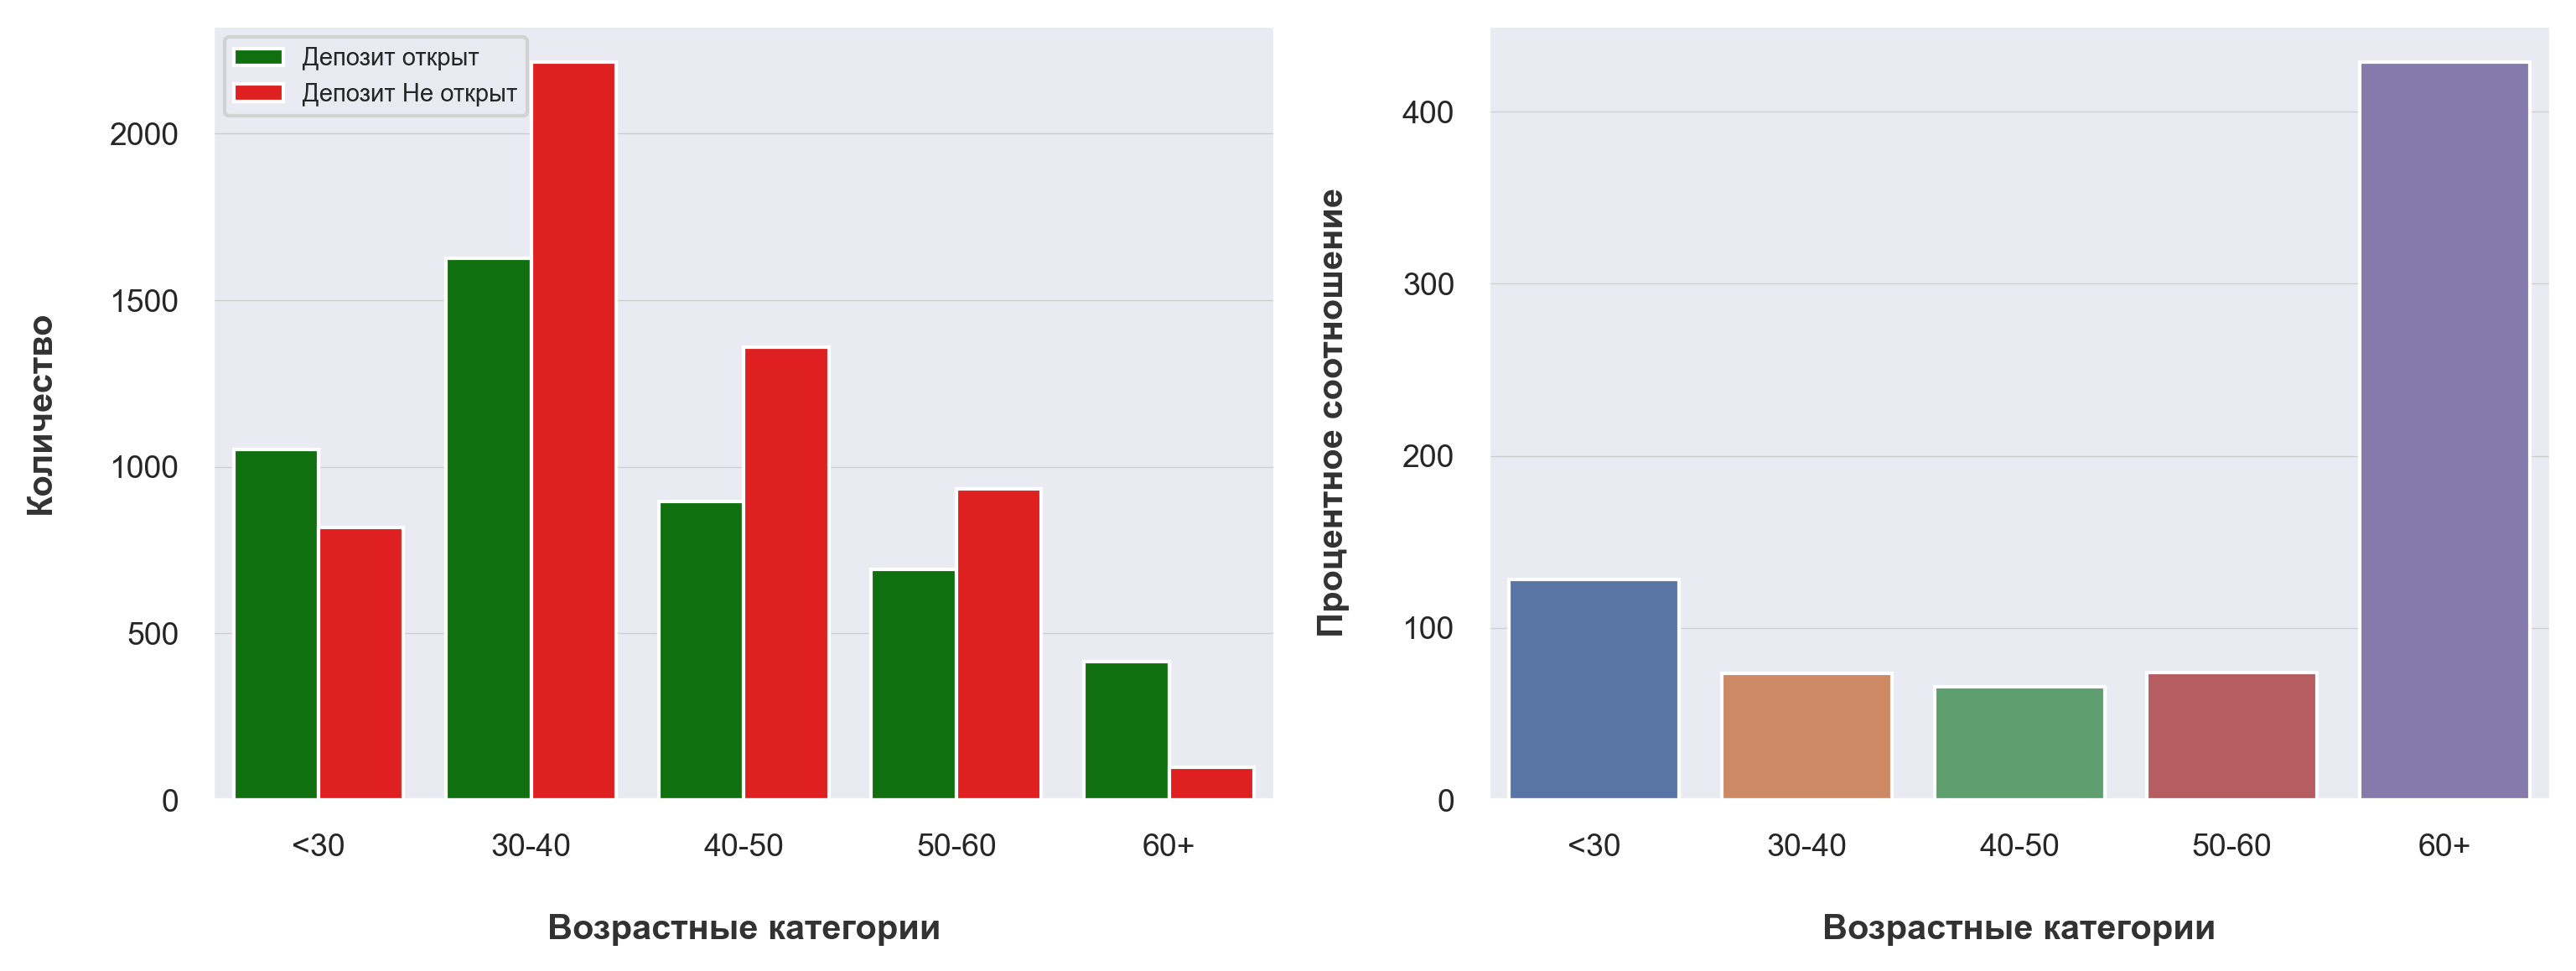

In [26]:

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=False, sharey=False)


sns.countplot(data=df_nb,
              x="age_group",
              hue="deposit",
              palette = ['green','red'],
              ax = ax1);

sns.barplot(data=df_ages,
              x="age_group",
              y="deposit_open_ratio",
              ax = ax2);


ax1.legend(loc = 'upper left', fontsize = 7, edgecolor = '.8', labels=['Депозит открыт', 'Депозит Не открыт']);

ax1.set_xlabel('Возрастные категории', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.set_ylabel('Количество', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.tick_params(axis='both', which='major', labelsize=9);

ax2.set_xlabel('Возрастные категории', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_ylabel('Процентное соотношение', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.tick_params(axis='both', which='major', labelsize=9);

Как мы видим, в возрастных категориях до 30 лет и после 60, самые выскоий процент открытия депозита, над отклоненением предложения

### Задания 9 и 10

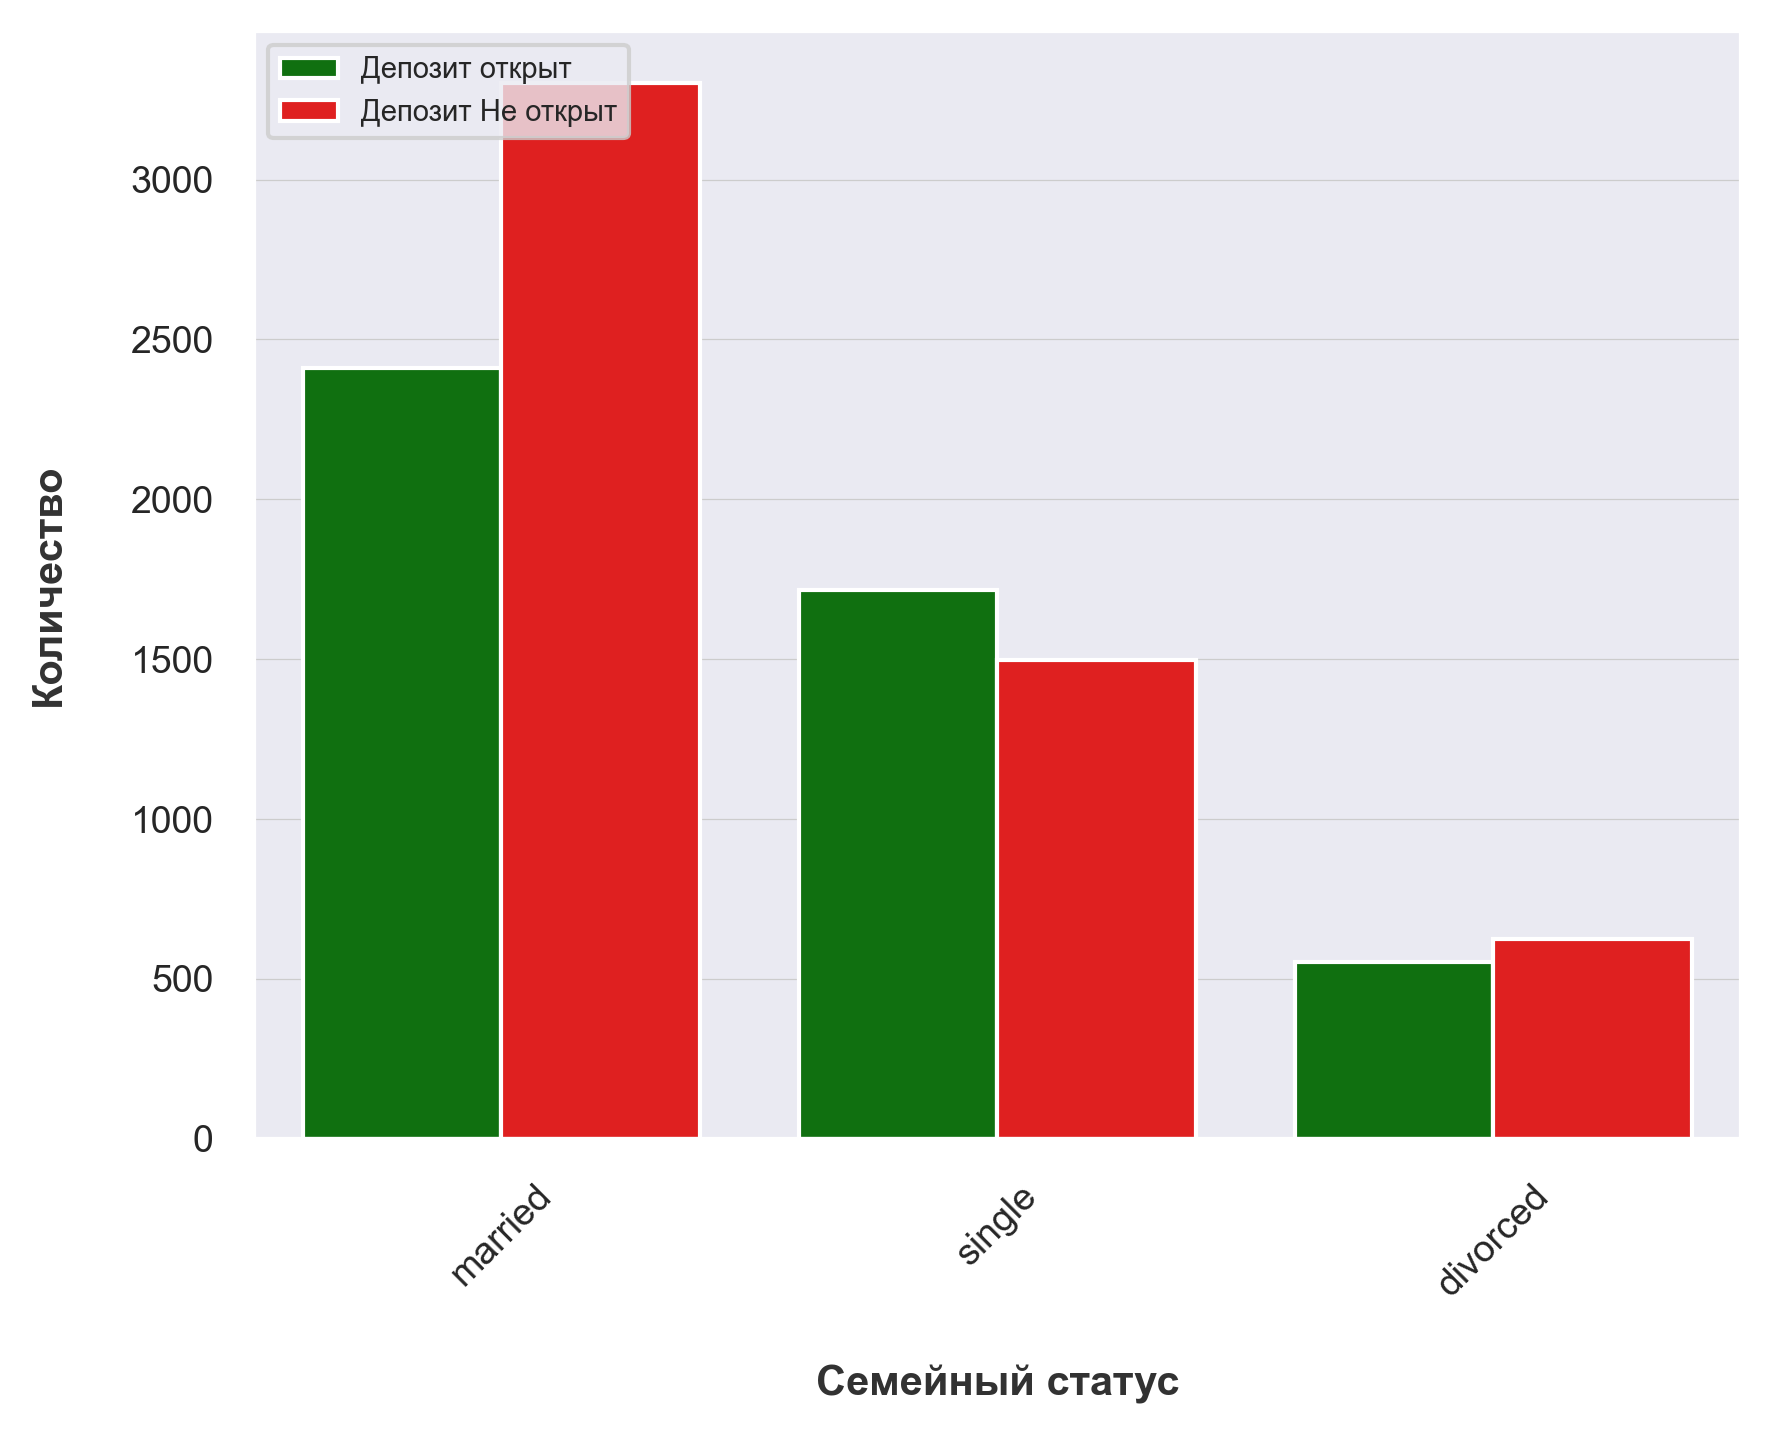

In [27]:
ax = sns.countplot(data=df_nb,
              x="marital",
              hue="deposit",
              palette=['green','red']
              );

ax.set_xlabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.set_ylabel('Количество', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.tick_params(axis='both', which='major', labelsize=9);
ax.legend(loc = 'upper left', fontsize = 7, edgecolor = '.8', labels=['Депозит открыт', 'Депозит Не открыт']);
ax.tick_params(axis='x', rotation=45)


Одинокие более склонны к открытию депозита

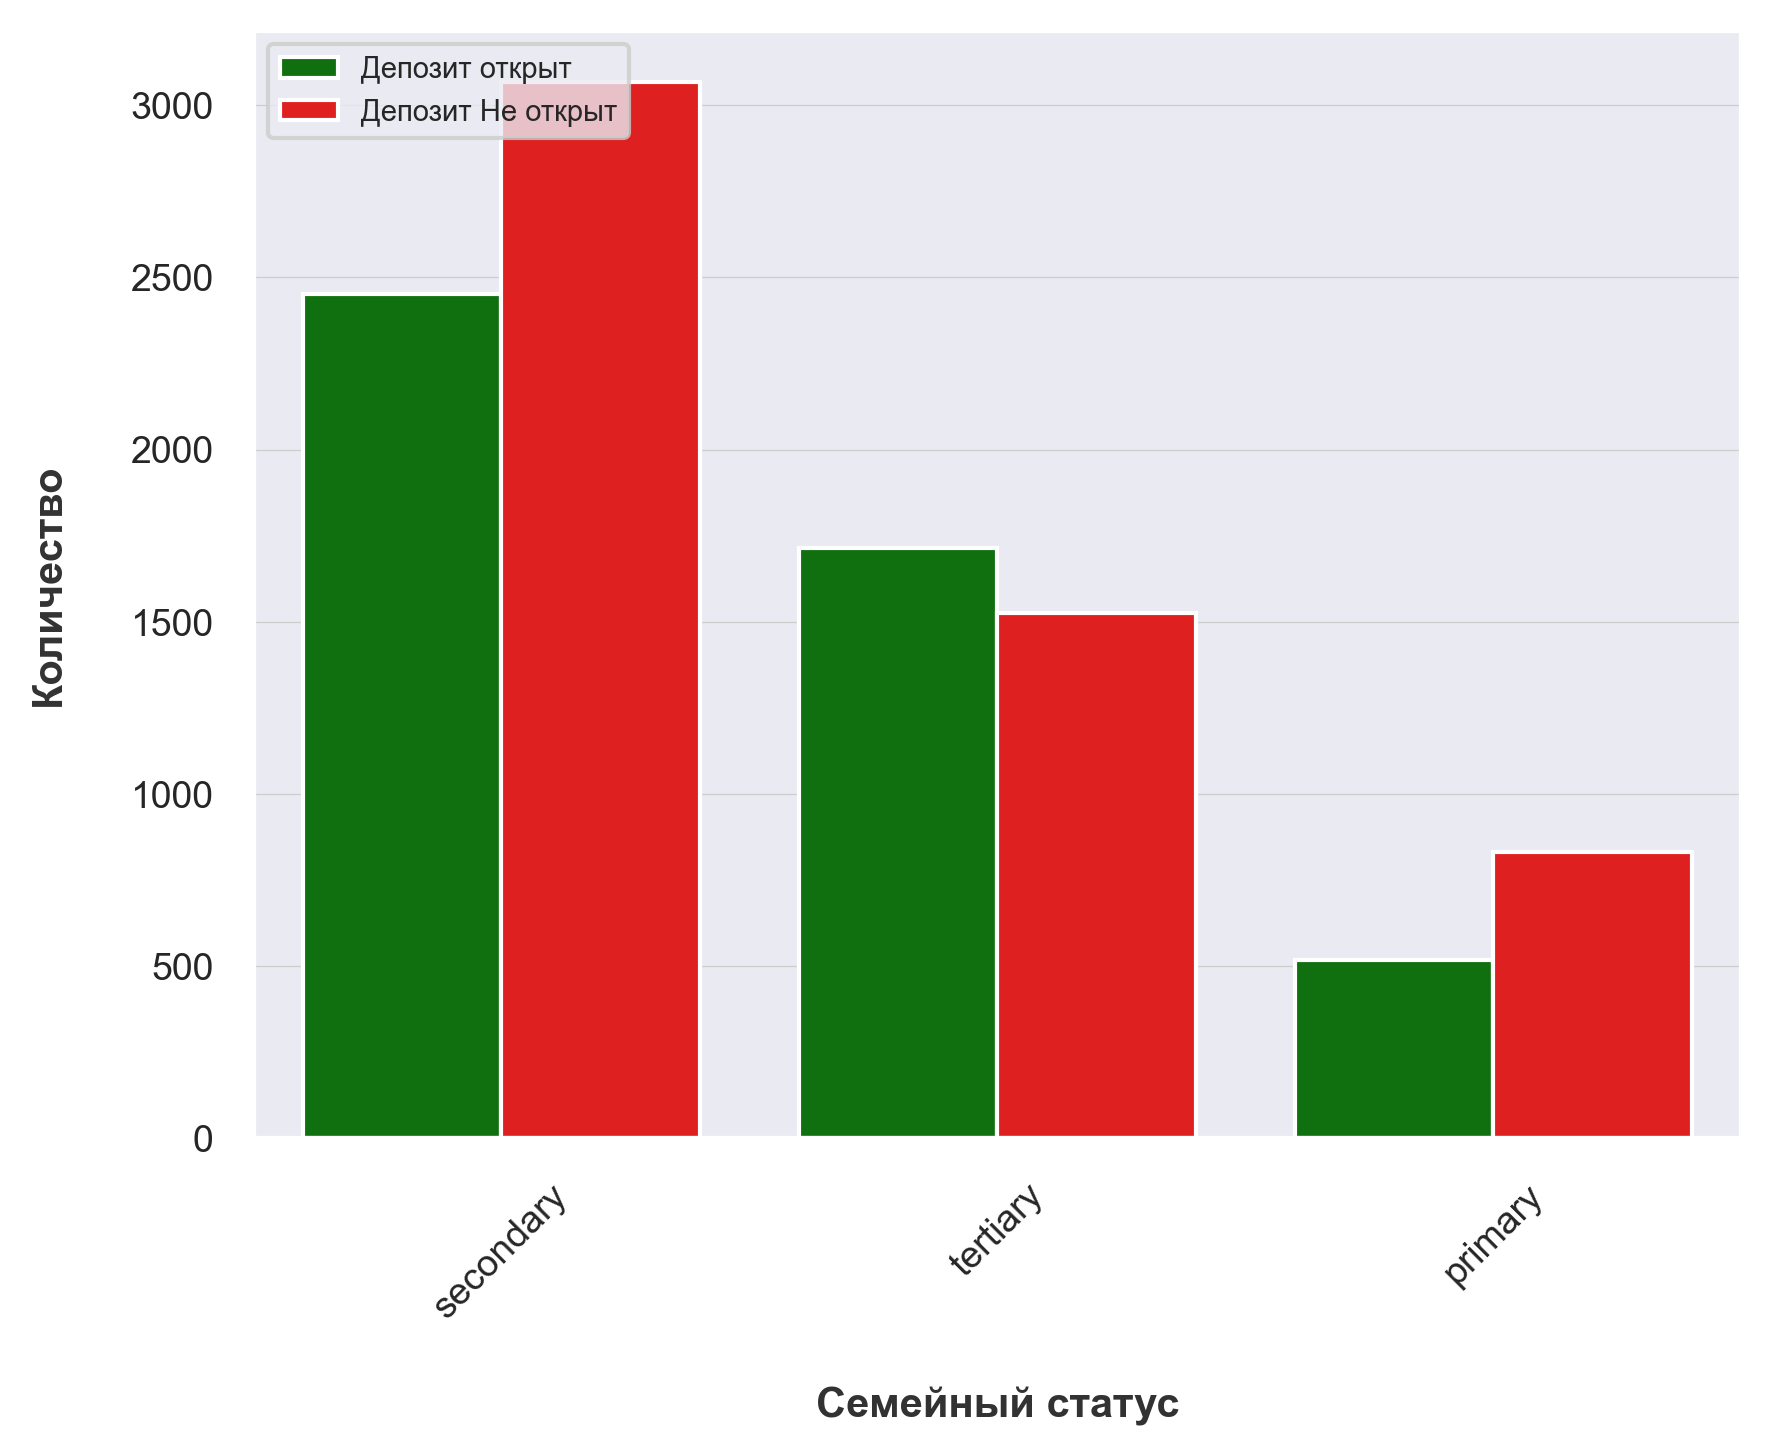

In [28]:
ax = sns.countplot(data=df_nb,
              x="education",
              hue="deposit",
              palette=['green','red']
              );

ax.set_xlabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.set_ylabel('Количество', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.tick_params(axis='both', which='major', labelsize=9);
ax.legend(loc = 'upper left', fontsize = 7, edgecolor = '.8', labels=['Депозит открыт', 'Депозит Не открыт']);
ax.tick_params(axis='x', rotation=45)

Клиенты с высшим образованием более склонны к открытию депозита

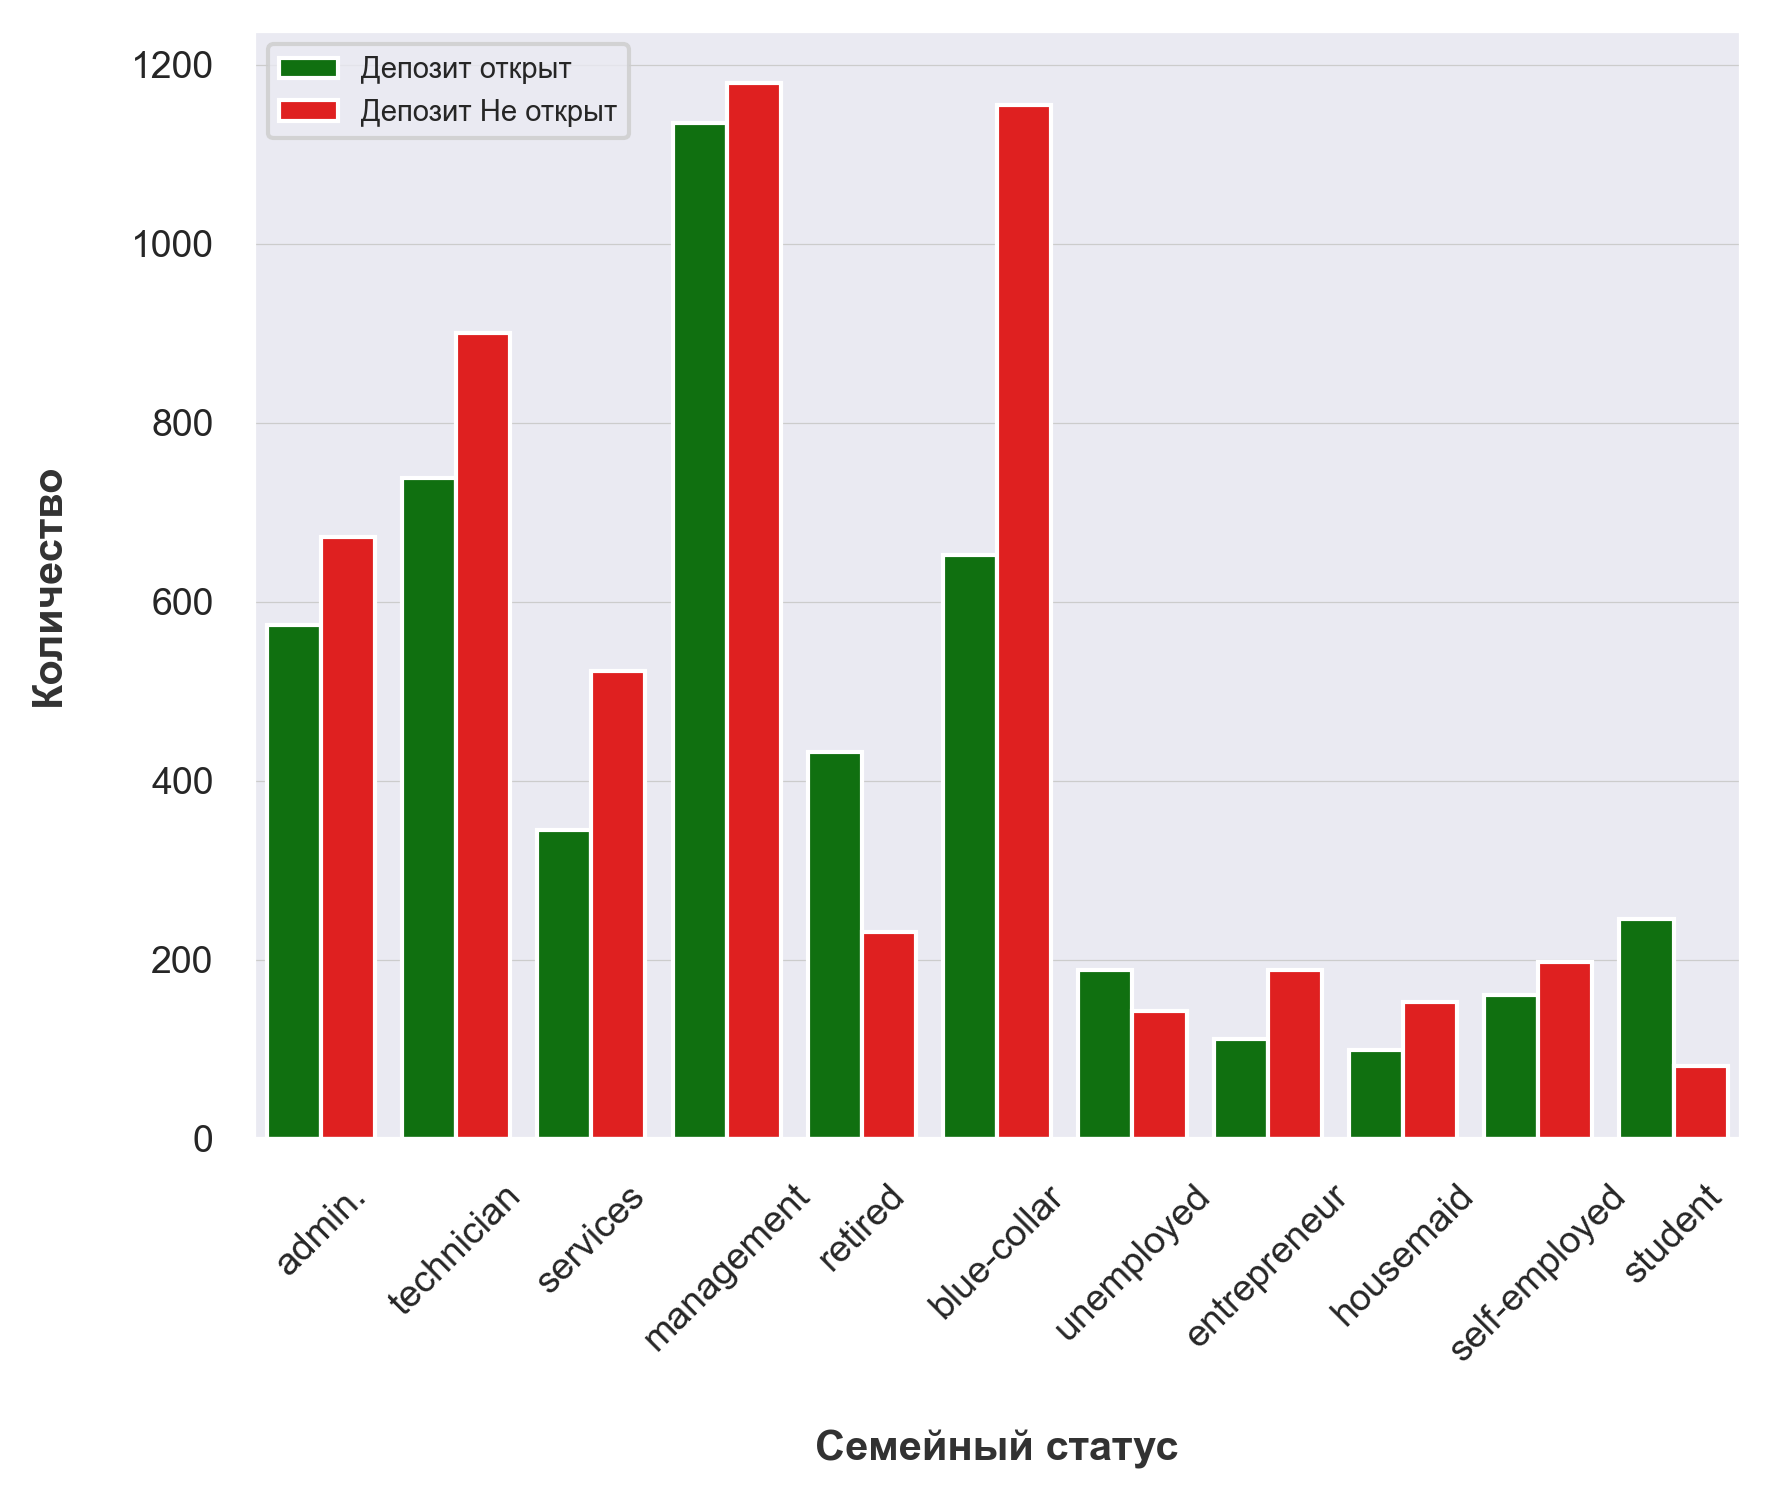

In [29]:
ax = sns.countplot(data=df_nb,
              x="job",
              hue="deposit",
              palette=['green','red']
              );

ax.set_xlabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.set_ylabel('Количество', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax.tick_params(axis='both', which='major', labelsize=9);
ax.legend(loc = 'upper left', fontsize = 7, edgecolor = '.8', labels=['Депозит открыт', 'Депозит Не открыт']);
ax.tick_params(axis='x', rotation=45)

Больше всего клиентов банка, которые заняты в сфере менеджмента

### Задание 11

In [30]:
mar_st_education_no_deposit = df_nb[df_nb.deposit == 'no'][['marital','education']]
mar_st_education_yes_deposit = df_nb[df_nb.deposit == 'yes'][['marital','education']]

crosstab_no_deposit = pd.crosstab(mar_st_education_no_deposit.marital, mar_st_education_no_deposit.education)
crosstab_yes_deposit = pd.crosstab(mar_st_education_yes_deposit.marital, mar_st_education_yes_deposit.education)

print(f"{Fore.LIGHTBLUE_EX}Самое большое пересечение двух категрий является:\
  {Fore.LIGHTGREEN_EX} {crosstab_no_deposit.max(axis = 0).idxmax()} <-> {crosstab_no_deposit.max(axis = 1).idxmax()}")


Самое большое пересечение двух категрий является:   secondary <-> married


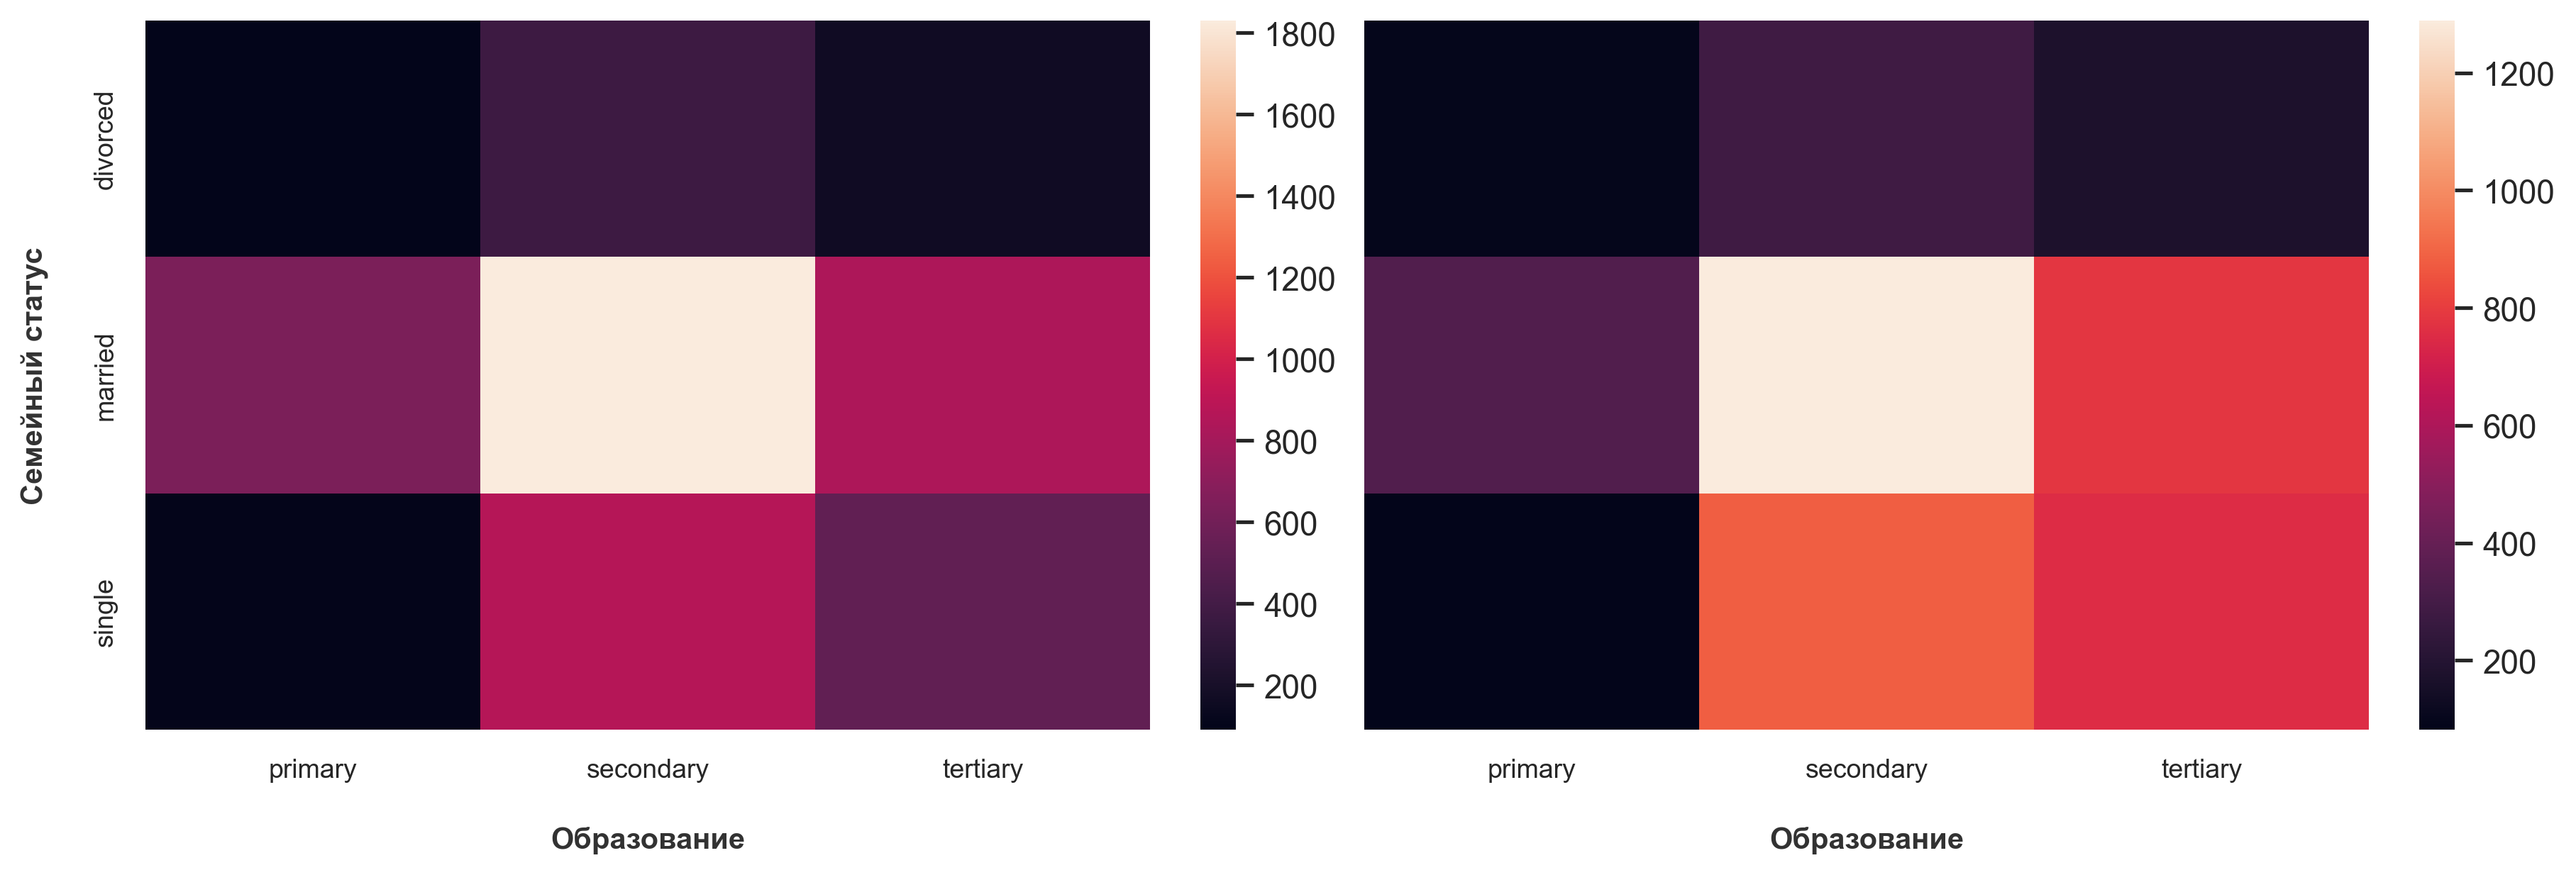

In [31]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True, sharey=True)

sns.heatmap(crosstab_no_deposit, ax = ax1);
sns.heatmap(crosstab_yes_deposit, ax = ax2);

ax1.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax1.set_ylabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 600})
ax2.set_ylabel('')
ax1.tick_params(axis='both', which='major', labelsize=9);
ax2.tick_params(axis='both', which='major', labelsize=9);

Тоже видим и на графиках, для обеих групп

## Часть 3: преобразование данных

### Задание 1

In [32]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_nb['education'] = lab_enc.fit_transform(df_nb['education'])
df_nb['age_group'] = lab_enc.fit_transform(df_nb['age_group'])
df_nb['education'].sum()

11995

### Задания 2 и 3

In [33]:
# Создание экземпляра класса LabelBinarizer()
lab_bin = LabelBinarizer()

# Кодирование признака
df_nb['deposit'] = lab_bin.fit_transform(df_nb['deposit'])
df_nb['deposit'].std().round(3)


0.499

In [34]:
# Кодирование признака

df_nb['default'] = lab_bin.fit_transform(df_nb['default'])
df_nb['housing'] = lab_bin.fit_transform(df_nb['housing'])
df_nb['loan'] = lab_bin.fit_transform(df_nb['loan'])

(df_nb['housing'].mean() + df_nb['default'].mean() + df_nb['loan'].mean()).round(3)

0.635

### Задание 4

In [35]:
df_nb_ext = pd.get_dummies(df_nb, columns=['job','marital','contact','month','poutcome'])

### Задания 5 и 6

In [36]:
# Обернем построение кореляционной диаграммы в функцию
def show_corr_heatmap(data, title, method):
    """Построения корреляционной диаграммы"""
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data.corr(method=method).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                annot_kws={"fontsize":6}, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='GnBu',
                fmt='.2f')
    ax_.set_title(title, fontsize=18)
    plt.show()

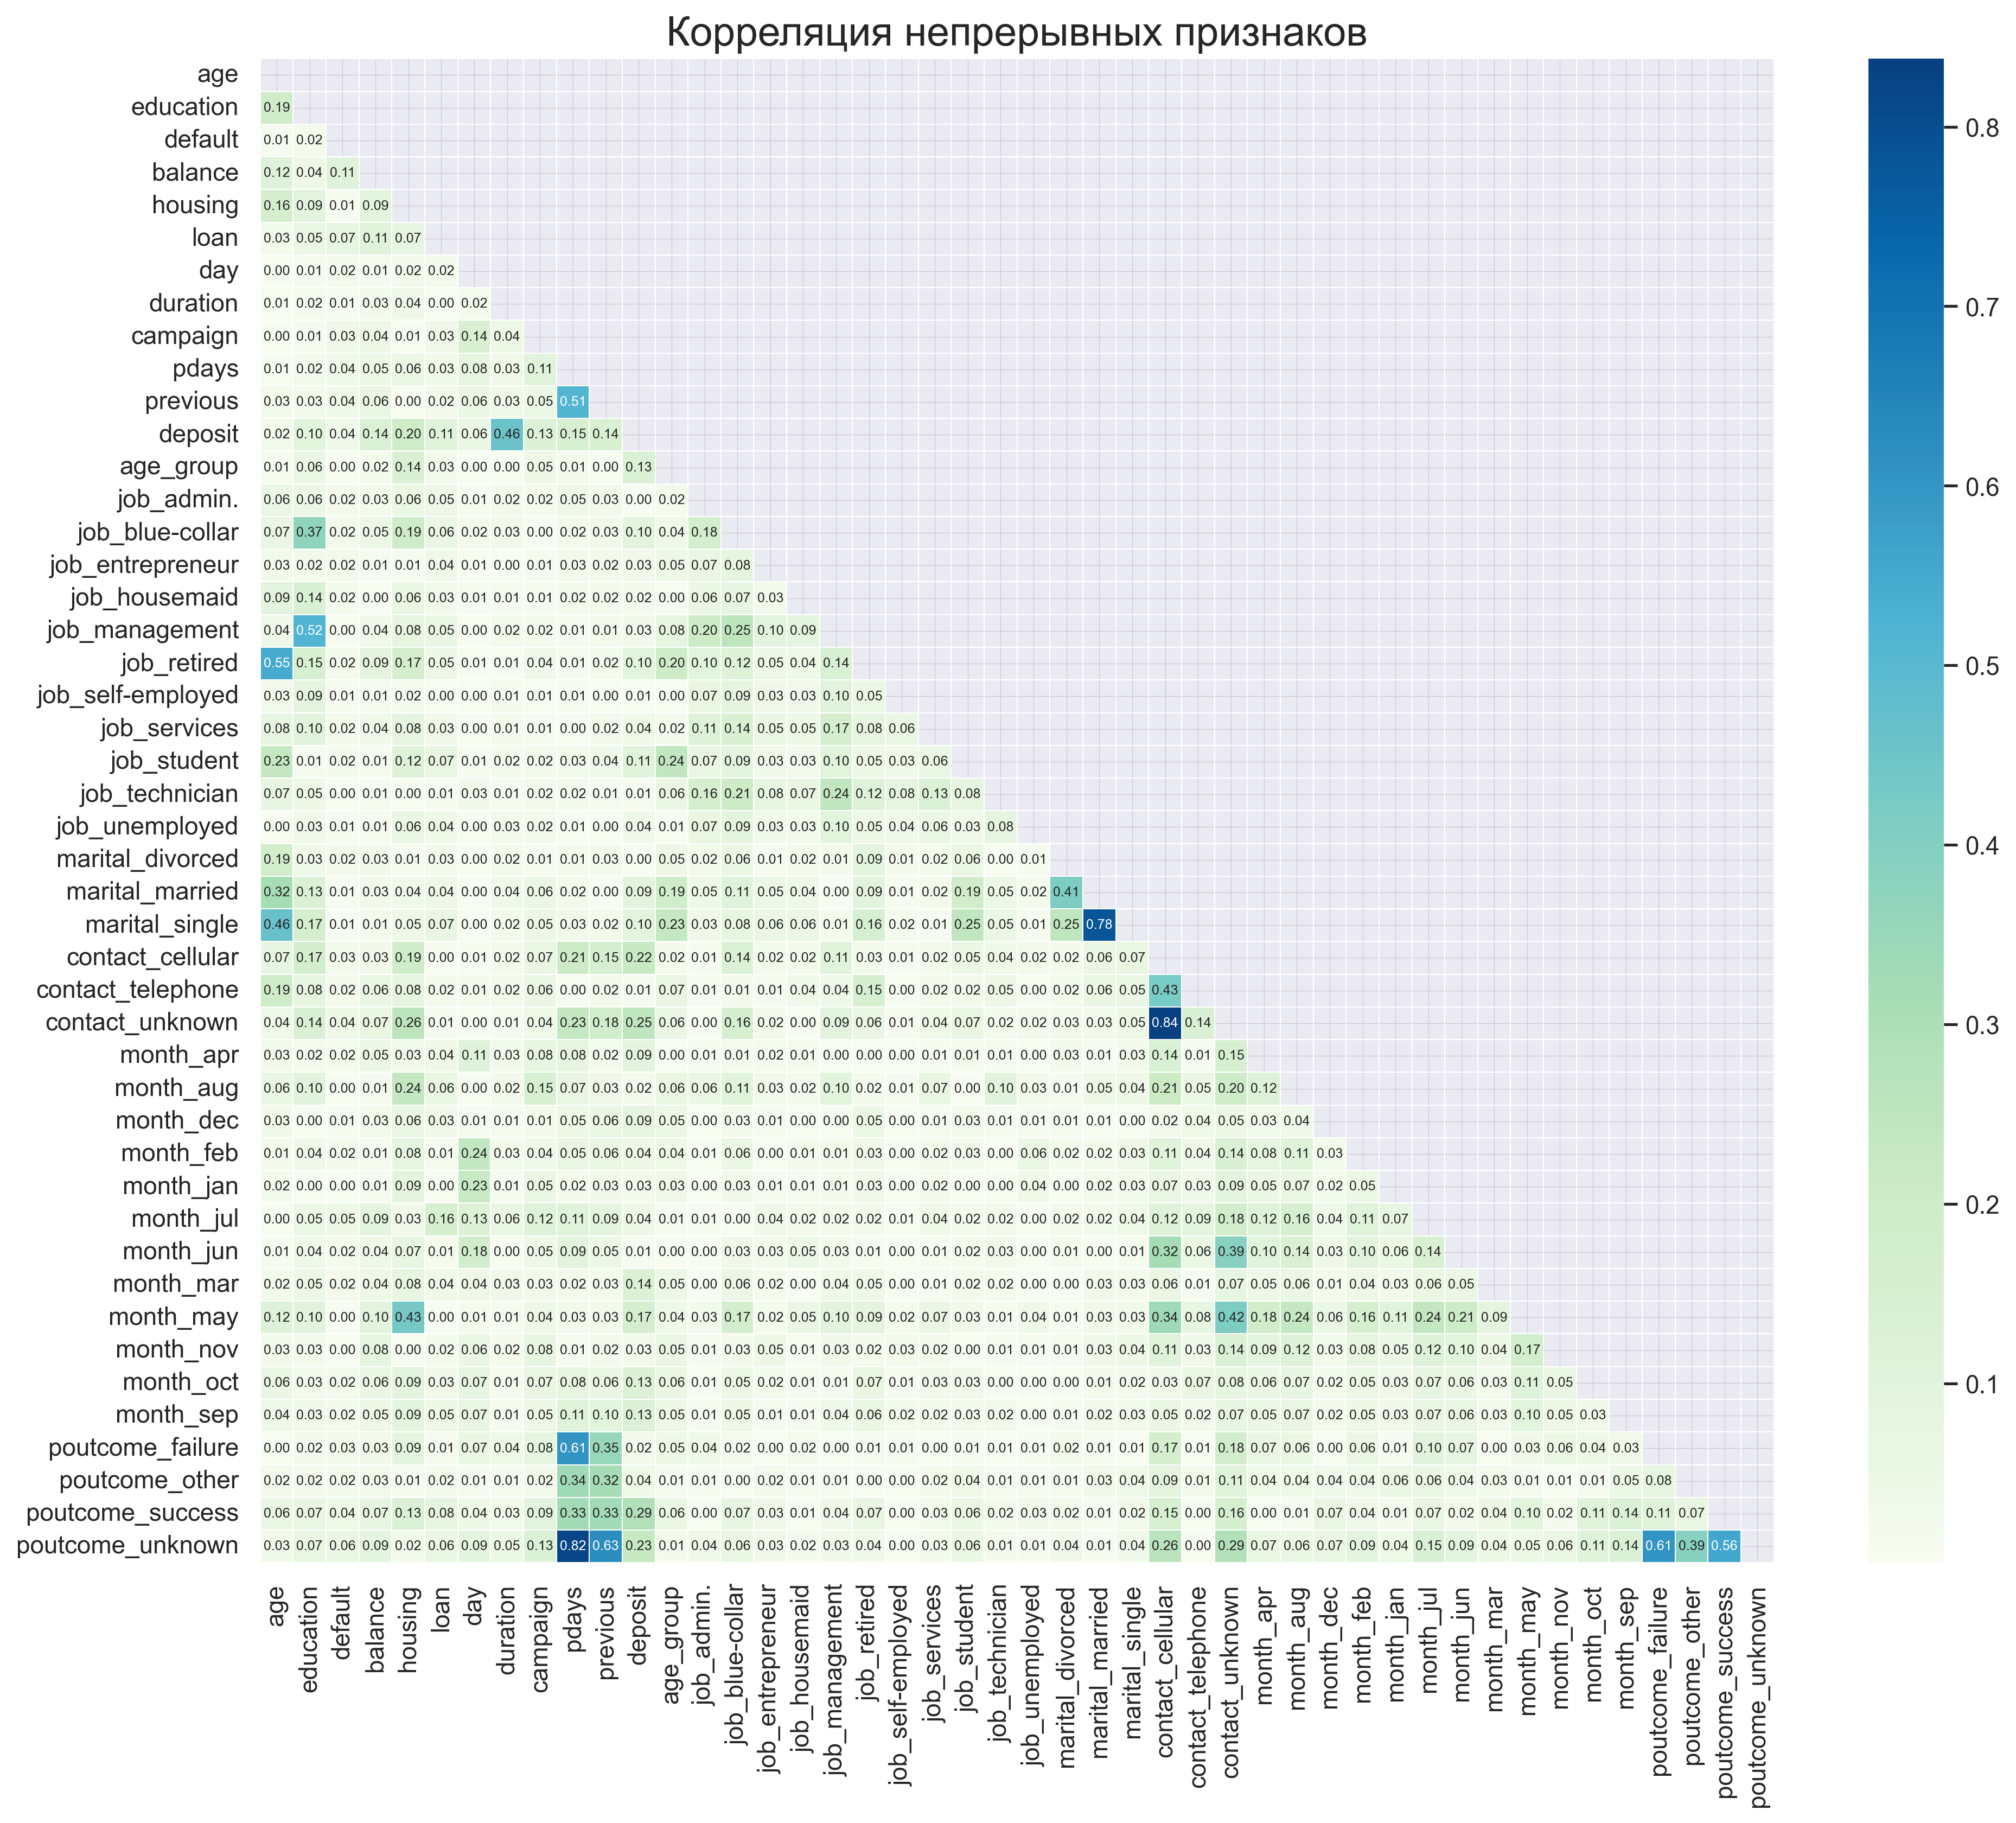

In [37]:
#строим диаграмму для непрерывных признаков:
show_corr_heatmap(df_nb_ext, 'Корреляция непрерывных признаков', method='pearson');

In [38]:
xx = df_nb_ext.drop(columns=['age_group']).corr().values
np.fill_diagonal(xx,0)

print(f"{Fore.LIGHTBLUE_EX}Максимальное значение корреляции:\
  {Fore.LIGHTGREEN_EX} {abs(xx).max().round(2)}")


Максимальное значение корреляции:   0.84


### Задания 7 и 8

In [39]:
X = df_nb_ext.drop(['deposit'], axis=1)
y = df_nb_ext['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')


print(f"{Fore.LIGHTBLUE_EX}Размер train выборки:\
  {Fore.LIGHTGREEN_EX} {X_train.shape}")
print(f"{Fore.LIGHTBLUE_EX}Размер test выборки:\
  {Fore.LIGHTGREEN_EX} {X_test.shape}")


Train:
deposit
0    0.53678
1    0.46322
Name: proportion, dtype: float64
Valid:
deposit
0    0.536732
1    0.463268
Name: proportion, dtype: float64
Размер train выборки:   (6770, 45)
Размер test выборки:   (3335, 45)


In [40]:
y_test.mean().round(2)

0.46

### Задание 9

In [45]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selectKBest_columns = list(selector.get_feature_names_out())
selectKBest_columns_list = '\n'.join(selectKBest_columns)
print(f"{Fore.LIGHTBLUE_EX}Выбранные признаки на основе фильтра корреляции Анова:\n{Fore.LIGHTGREEN_EX}{selectKBest_columns_list}")

Выбранные признаки на основе фильтра корреляции Анова:
balance
housing
duration
campaign
pdays
previous
age_group
contact_cellular
contact_unknown
month_mar
month_may
month_oct
month_sep
poutcome_success
poutcome_unknown


### Задание 10

In [46]:
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train[selectKBest_columns])                           
X_train_scaled = scaler.transform(X_train[selectKBest_columns])    
X_test_scaled = scaler.transform(X_test[selectKBest_columns])      

print(f"{Fore.LIGHTBLUE_EX}Среднее арифмитическое для первого предиктора:\
  {Fore.LIGHTGREEN_EX}{X_test_scaled[:, 0].mean().round(2)}")



Среднее арифмитическое для первого предиктора:  0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [53]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX}Accuracy для тестовой выборки:\
  {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_test, y_pred).round(2)}")



Accuracy для тестовой выборки:  0.81


### Задания 2,3,4

In [55]:
log_d_tree = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42, 
)

log_d_tree.fit(X_train_scaled, y_train)

y_train_pred = log_d_tree.predict(X_train_scaled)
y_pred = log_d_tree.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX}Accuracy для трейн выборки:\
  {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_train, y_train_pred).round(2)}")

print(f"{Fore.LIGHTBLUE_EX}Accuracy для тестовой выборки:\
  {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_test, y_pred).round(2)}")


Accuracy для трейн выборки:  1.0
Accuracy для тестовой выборки:  0.75


Как мы видим, у нас явное переобучение модели.

Проверим, как будет меняться значение accuracy для train и test выборок при глубине дерева в диапазоне от 1 до 10

In [65]:
max_depth_list = np.linspace(1, 10, 10)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for max_depth in max_depth_list:
  log_d_tree = tree.DecisionTreeClassifier(
      criterion='entropy', 
      random_state=42,
      max_depth=max_depth 
  )
  log_d_tree.fit(X_train_scaled, y_train)

  y_train_pred = log_d_tree.predict(X_train_scaled)
  y_pred = log_d_tree.predict(X_test_scaled)


  train_scores.append(metrics.accuracy_score(y_train, y_train_pred).round(2))
  test_scores.append(metrics.accuracy_score(y_test, y_pred).round(2))


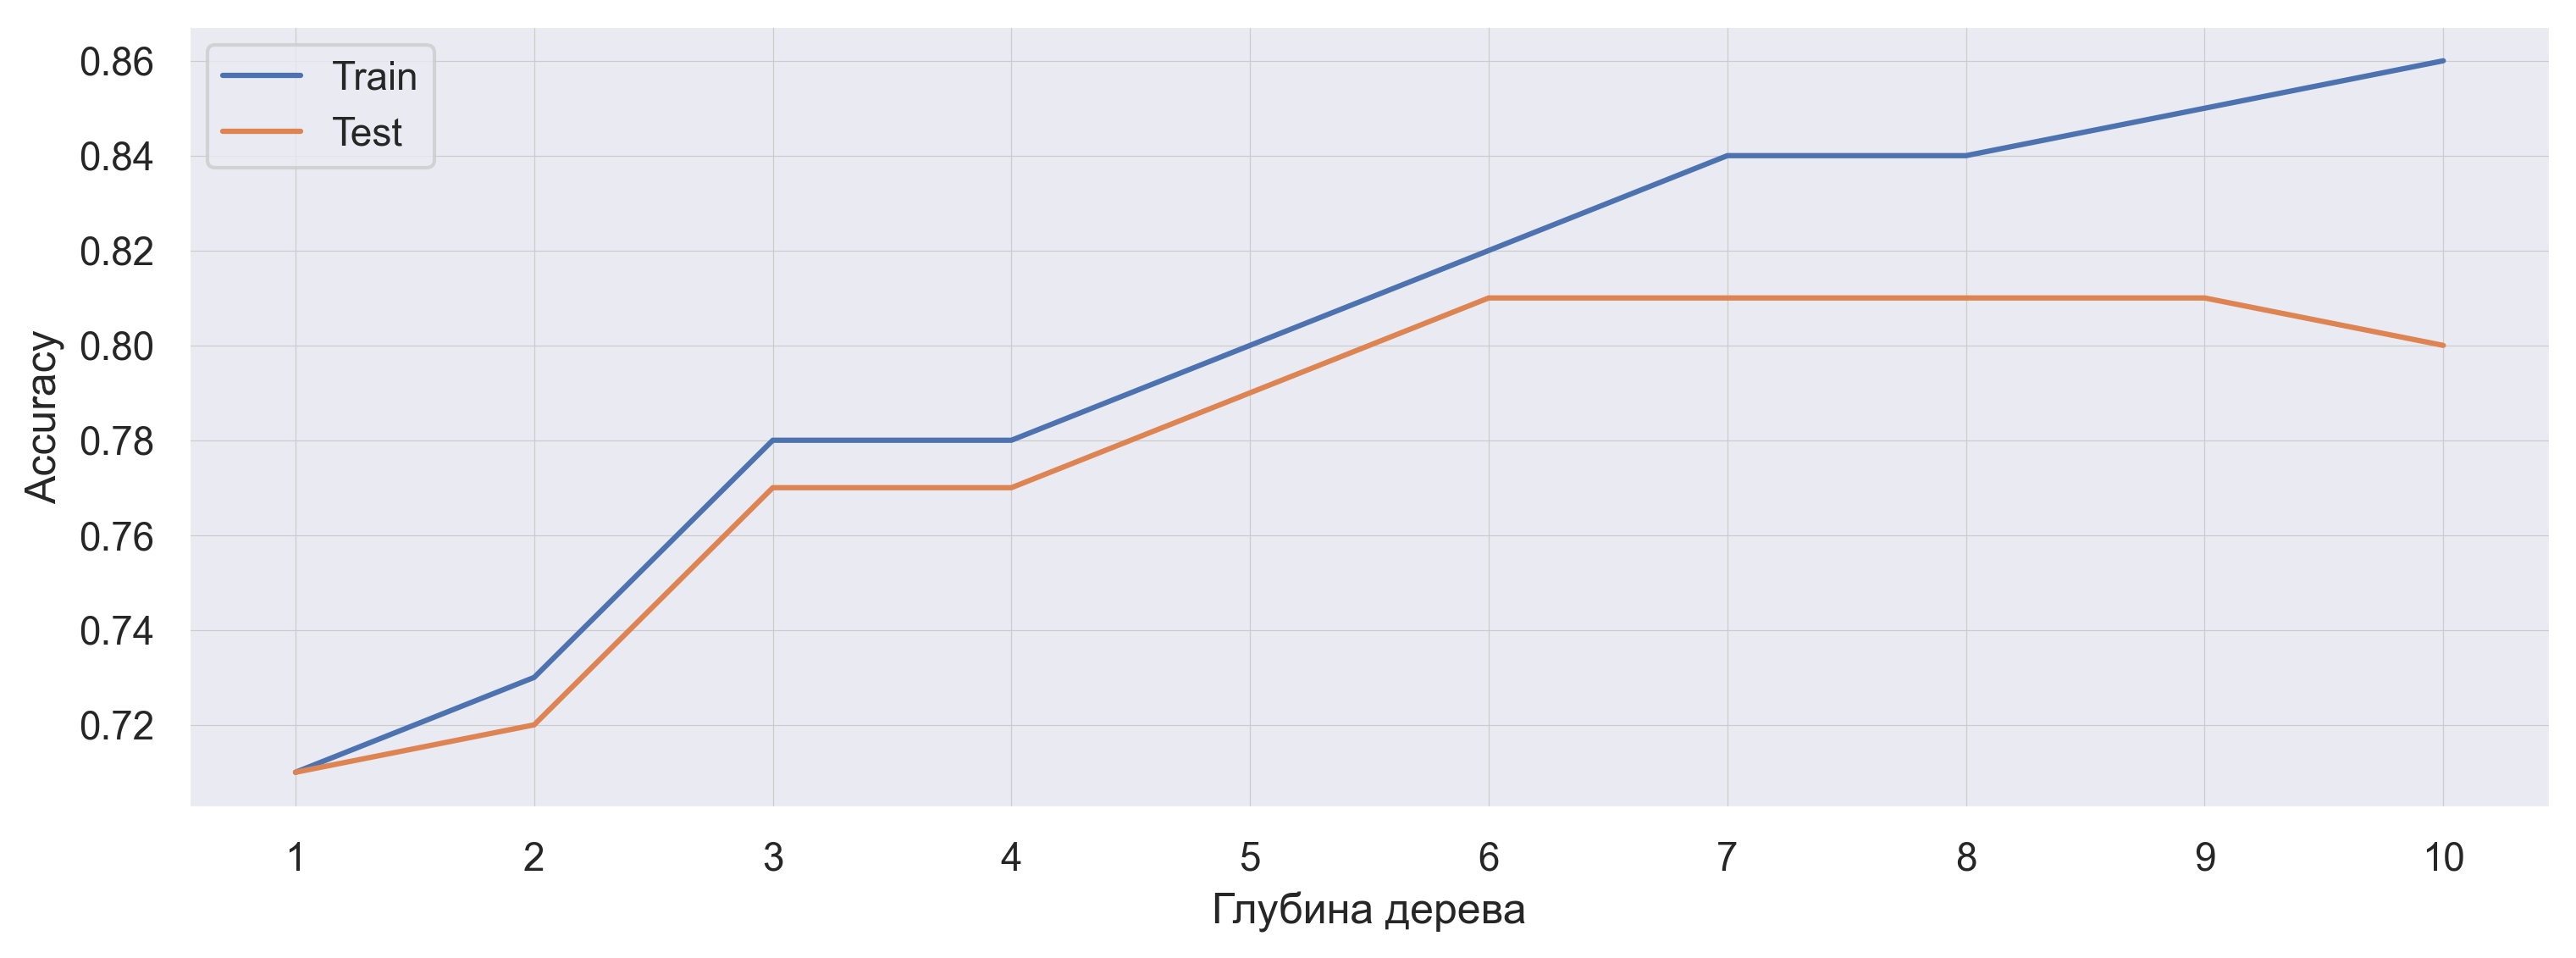

In [69]:
#Визуализируем изменение accuracy в зависимости от параметра грубина дерева для test и train выборок
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depth_list, train_scores, label='Train') 
ax.plot(max_depth_list, test_scores, label='Test') 
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy') 
ax.set_xticks(max_depth_list) 
ax.legend(); 

Как мы видим, максимально сбалансированный результат с наивысшым значением accuracy наблюдается при глубине дерева равным 6-ти

In [70]:
log_d_tree = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42, 
    max_depth=6,
)

log_d_tree.fit(X_train_scaled, y_train)

y_train_pred = log_d_tree.predict(X_train_scaled)
y_pred = log_d_tree.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX}Accuracy для трейн выборки:\
  {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_train, y_train_pred).round(2)}")

print(f"{Fore.LIGHTBLUE_EX}Accuracy для тестовой выборки:\
  {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_test, y_pred).round(2)}")

Accuracy для трейн выборки:  0.82
Accuracy для тестовой выборки:  0.81


### Задание 5

In [83]:
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              },

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42,), 
    param_grid=param_grid, 
    cv=3, 
    scoring=('f1'),
    return_train_score=True,
    n_jobs = -1
)  

%time grid_search.fit(X_train_scaled, y_train) 

print(f"{Fore.LIGHTBLUE_EX} Наилучшие значения гиперпараметров: {Fore.LIGHTGREEN_EX}{grid_search.best_params_}{Fore.RESET}")

y_test_pred = grid_search.predict(X_test_scaled)
metrics_test = metrics.f1_score(y_test, y_test_pred).round(2)
print(f"{Fore.LIGHTBLUE_EX} Наилучшее значения f1: {Fore.LIGHTGREEN_EX}{metrics_test}{Fore.RESET}")



CPU times: total: 109 ms
Wall time: 129 ms
 Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
 Наилучшее значения f1: 0.8


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [98]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10,
                                     random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX} Accuracy score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_test, y_pred).round(6)}{Fore.RESET}")
print(f"{Fore.LIGHTBLUE_EX} Recall score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.recall_score(y_test, y_pred).round(6)}{Fore.RESET}")
print(f"{Fore.LIGHTBLUE_EX} F1 score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.f1_score(y_test, y_pred).round(6)}{Fore.RESET}")


 Accuracy score на тестовй выборке: 0.826687
 Recall score на тестовй выборке: 0.83301
 F1 score на тестовй выборке: 0.816624


### Задания 2 и 3

In [99]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX} Accuracy score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.accuracy_score(y_test, y_pred).round(6)}{Fore.RESET}")
print(f"{Fore.LIGHTBLUE_EX} Recall score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.recall_score(y_test, y_pred).round(6)}{Fore.RESET}")
print(f"{Fore.LIGHTBLUE_EX} F1 score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.f1_score(y_test, y_pred).round(6)}{Fore.RESET}")

 Accuracy score на тестовй выборке: 0.826387
 Recall score на тестовй выборке: 0.831715
 F1 score на тестовй выборке: 0.816132


### Задание 4

In [100]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_pred = stack.predict(X_test_scaled)

print(f"{Fore.LIGHTBLUE_EX} Precision score на тестовой выборке: {Fore.LIGHTGREEN_EX}{metrics.precision_score(y_test, y_pred).round(2)}{Fore.RESET}")


 Precision score на тестовой выборке: 0.81


### Задание 5

In [115]:
gb.feature_importances_[0]

0.05795212468091972

In [129]:
# Для Градиентного бустинга найдем значимость признаков
pd.concat([pd.Series(selectKBest_columns), pd.Series(gb.feature_importances_)], axis=1).\
  set_axis(['feature','importance'], axis = 1).sort_values(by='importance', ascending=False)

,feature,importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582
0,balance,0.057952
4,pdays,0.055083
1,housing,0.047725
6,age_group,0.039902
9,month_mar,0.027819
11,month_oct,0.019880
10,month_may,0.015245


### Задания 6,7,8

In [143]:
def optuna_func(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))
  # score = cross_val_score(model, X_train, y_train, cv = 5, scoring="f1", n_jobs = -1).mean()  
  return score

In [144]:
%time

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_ranFor_opt = optuna.create_study(study_name="RandomForestClassifier Optuna Optimization", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_ranFor_opt.optimize(optuna_func, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_ranFor_opt.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_ranFor_opt.best_value))

[I 2023-04-26 20:16:31,075] A new study created in memory with name: RandomForestClassifier Optuna Optimization


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-04-26 20:16:31,792] Trial 0 finished with value: 0.8210792047964658 and parameters: {'n_estimators': 130, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8210792047964658.
[I 2023-04-26 20:16:32,677] Trial 1 finished with value: 0.8205938092229943 and parameters: {'n_estimators': 180, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8210792047964658.
[I 2023-04-26 20:16:33,272] Trial 2 finished with value: 0.816055625790139 and parameters: {'n_estimators': 106, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8210792047964658.
[I 2023-04-26 20:16:34,085] Trial 3 finished with value: 0.8153067678684377 and parameters: {'n_estimators': 175, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8210792047964658.
[I 2023-04-26 20:16:34,742] Trial 4 finished with value: 0.8195583596214511 and parameters: {'n_estimators': 127, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8210

Наилучшие значения гиперпараметров {'n_estimators': 151, 'max_depth': 17, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [145]:
optuna.visualization.plot_optimization_history(study_ranFor_opt, target_name="f1_score")

In [146]:
optuna.visualization.plot_param_importances(study_ranFor_opt, target_name="f1_score")

In [147]:
optuna.visualization.plot_contour(study_ranFor_opt, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")